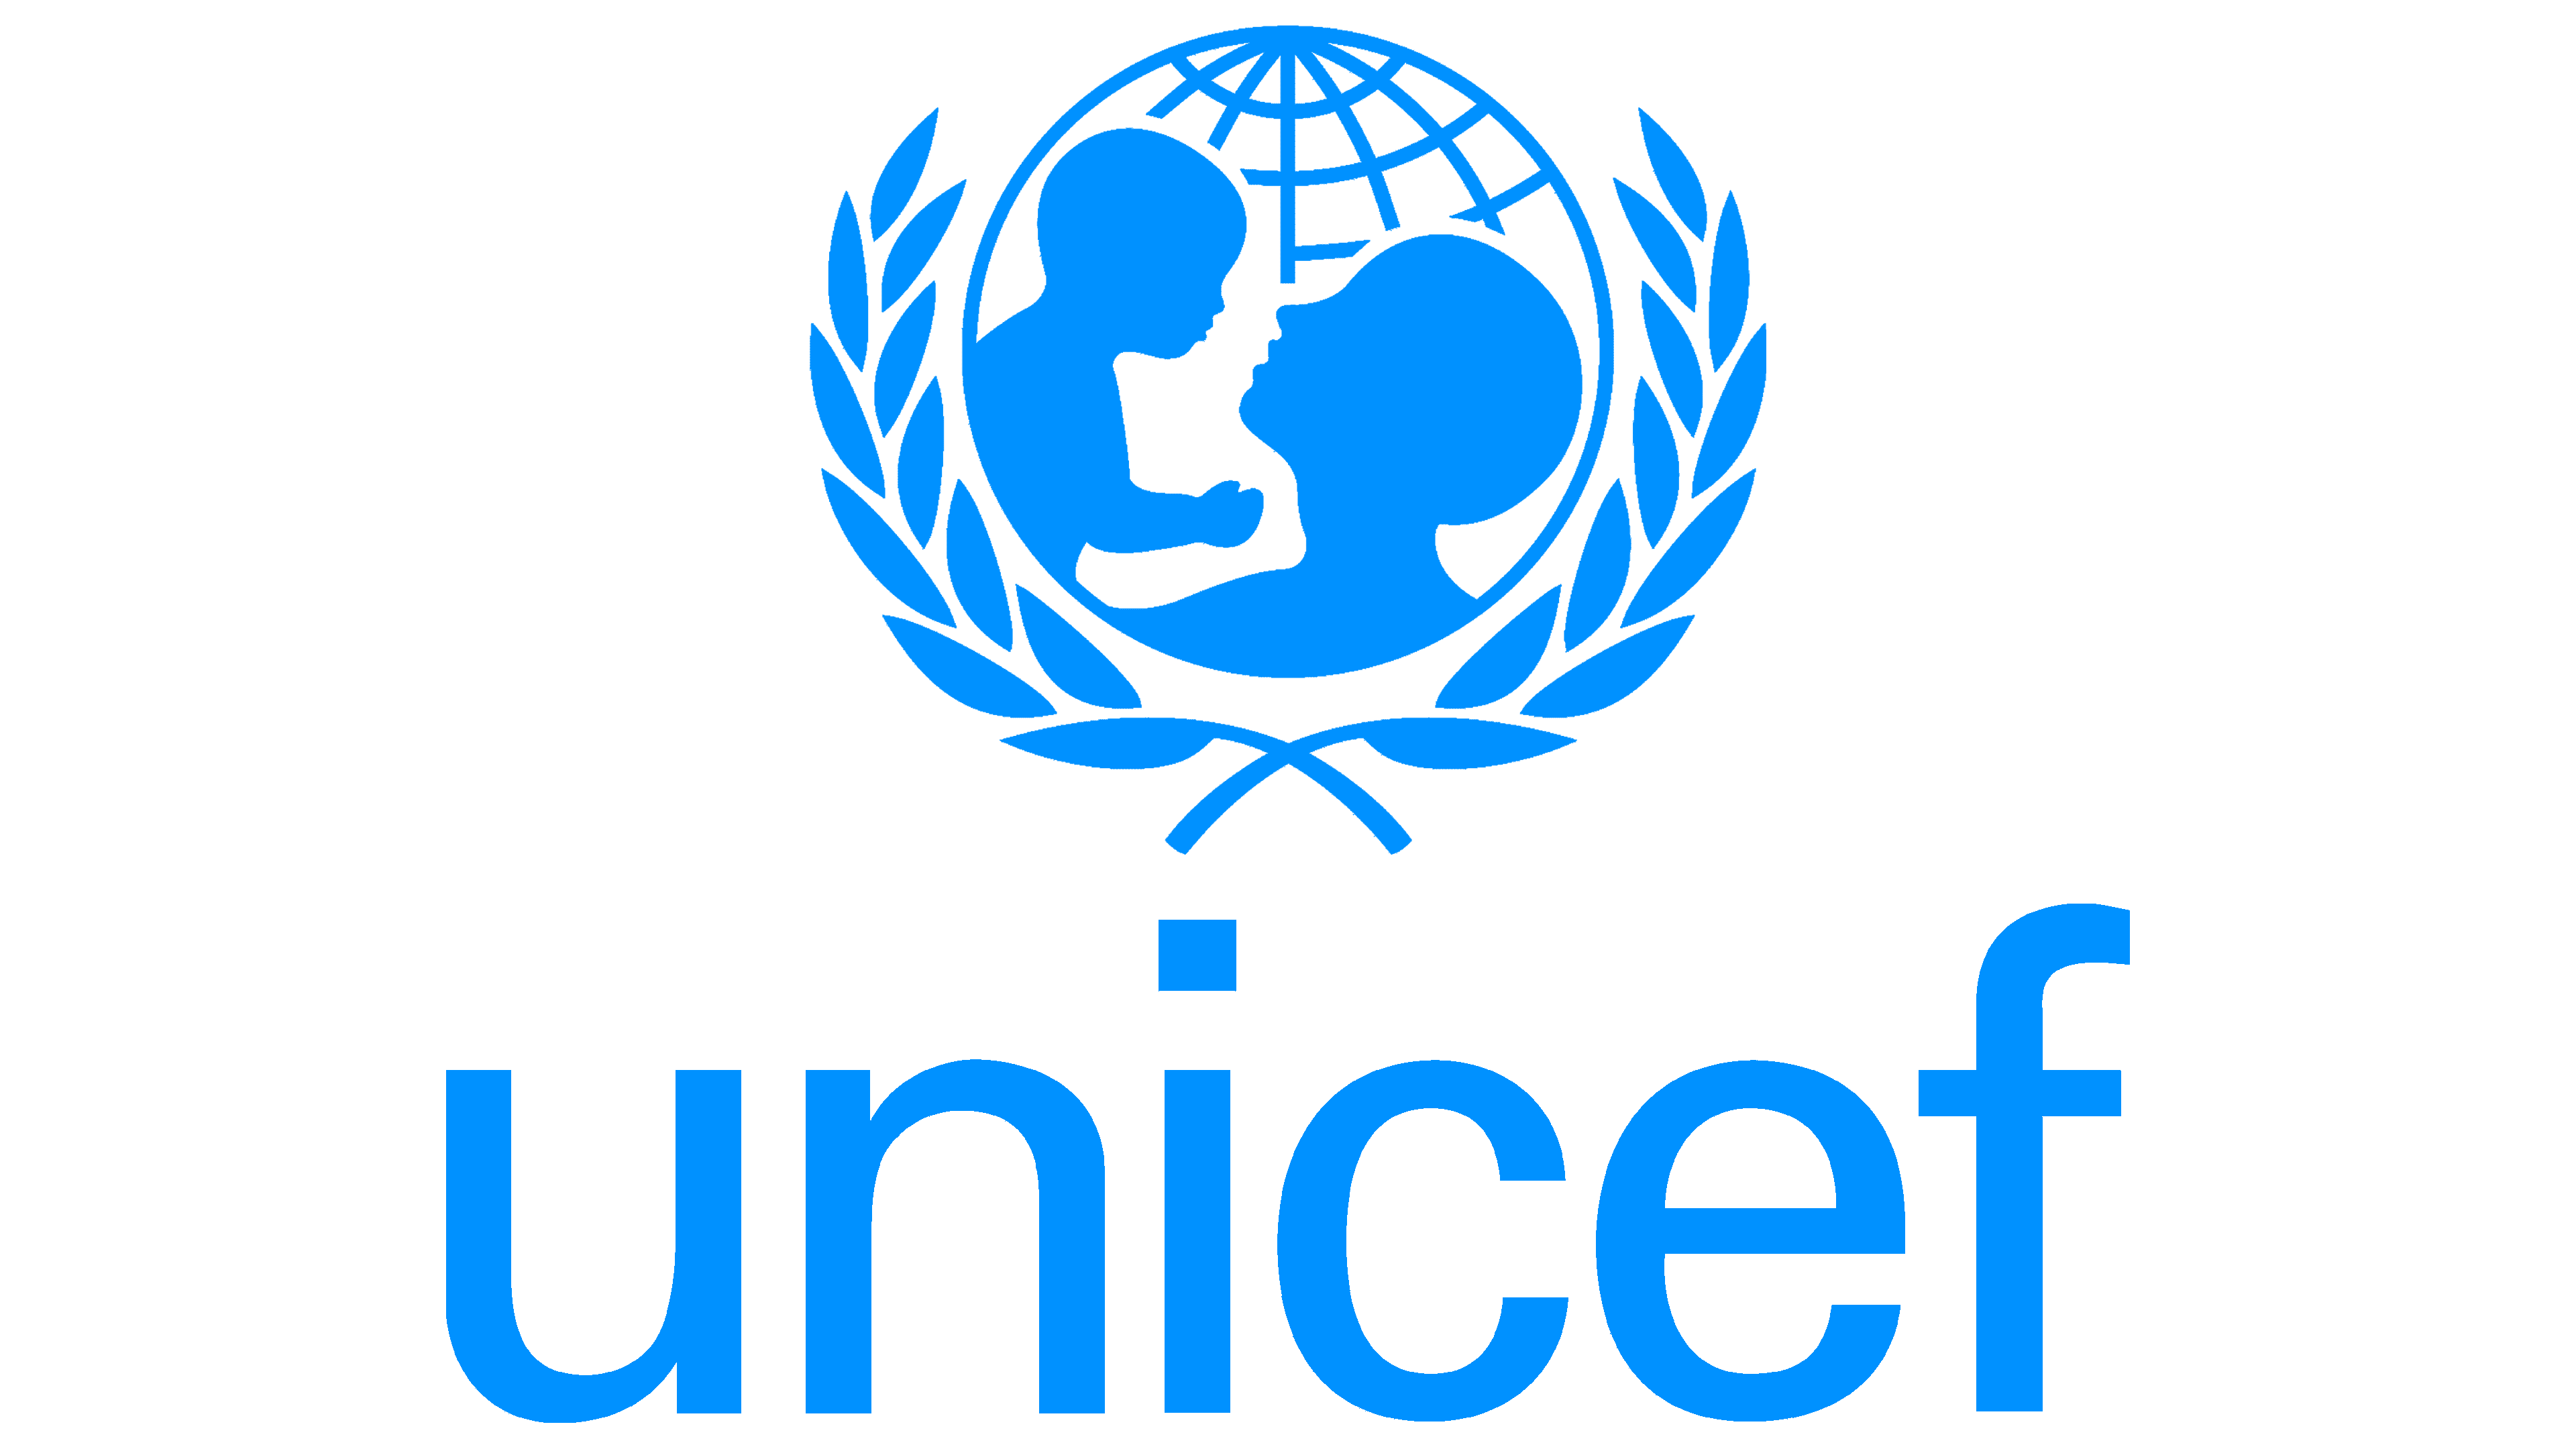

Image from: https://static.6seconds.org/wp-content/uploads/2022/04/19111201/UNICEF-Emblem.png

### Authors: Juana Tavera, Sarah Jack, and Mackoy Staloch

# Predicting Well Functionality in Tanzania for UNICEF

Presented by World Wide Water

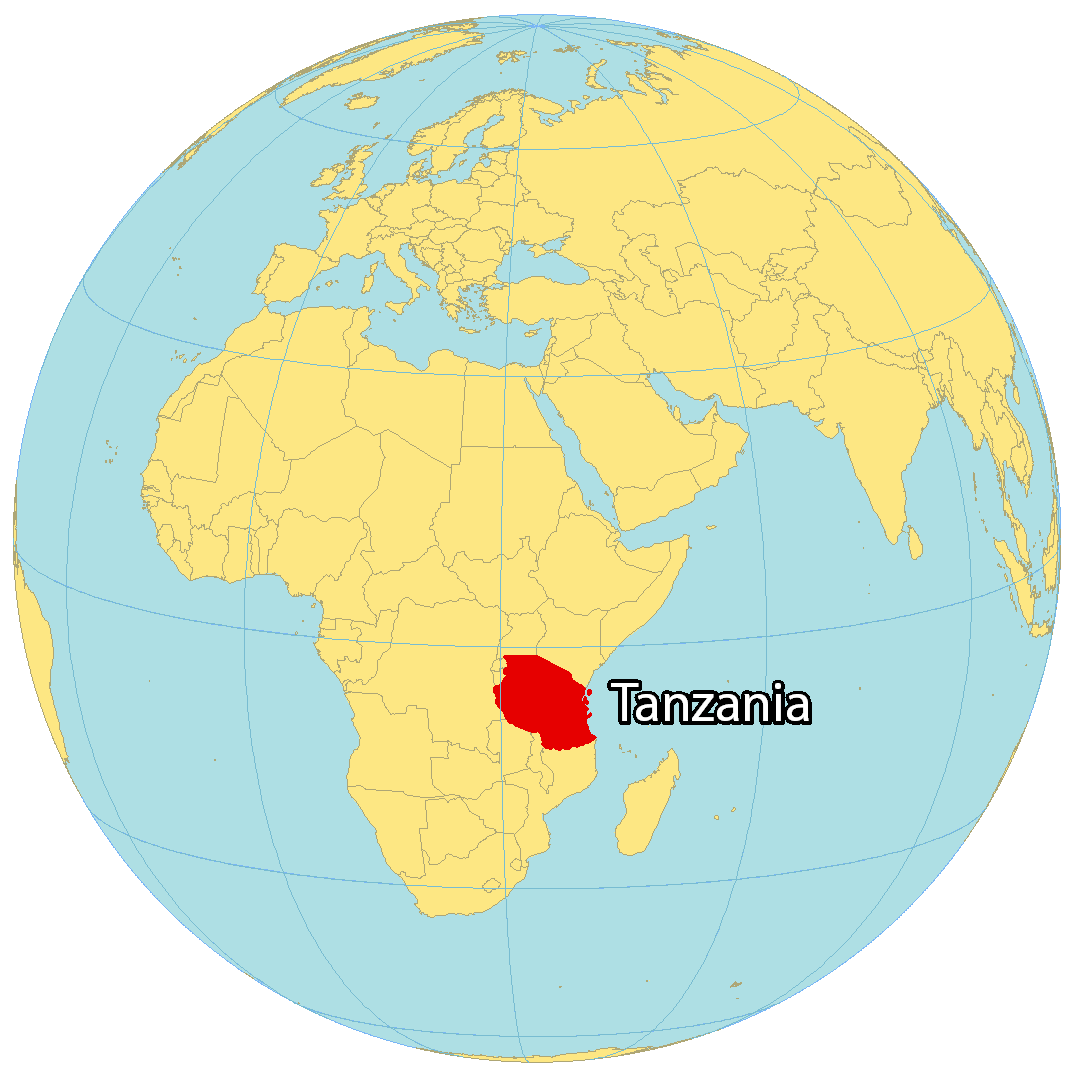

Image from https://gisgeography.com/wp-content/uploads/2017/09/Tanzania-World-Map.png

## Business Problem

UNICEF has asked the team at World Wide Water to develop a model that can help predict well functionality in Tanzania. World Wide Water used the data set from DrivenData, which contains information about wells from 1960 - 2013 with roughly 54,000 wells. The team found that the age of the well, extraction type, and location strongly influence whether the well is functional or not.

## Data Understanding

### Set Up: Import Libraries, Load, and Examine Data

In [14]:
# Imports
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import MissingIndicator, SimpleImputer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, precision_score, recall_score, plot_roc_curve, plot_confusion_matrix
from sklearn.metrics import log_loss, classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from collections import Counter
from xgboost import XGBClassifier
from scipy.stats import uniform
import warnings
warnings.filterwarnings('ignore')

The datasets used is from the DrivenData classification challenge. That information can be found here: https://www.drivendata.org/accounts/login/?next=/competitions/7/pump-it-up-data-mining-the-water-table/data/

In [15]:
# Read in the data set
df = pd.read_csv("data/tanzania_wells.csv", index_col = 0)

In [16]:
# Display data
display(df.head())
display(df.info())

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

None

In [17]:
# Examining our target
df['status_group'].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [18]:
# Look at null values
df.isna().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

From the .info( ) can see that there are a lot of categorical variables - there are 31 of them. There are some columns such as date_recorded that will not give us any insights such as `data_recorded` (when the row was entered) and `recorded_by` (group entering this row of the data). Looking at the data dictionary can see that some of these columns are duplicated. Lets take a closer look at the categorical features to see which ones we would like to keep. In general would to keep almost all features which are numerical since there are so few.

Columns that have null values are:
- `funder`: who funded the well
- `installer`: organization that installed the well
- `subvillage`: geographic location
- `public_meeting`: true/false
- `scheme_management`: who operates the waterpoint
- `scheme_name`: who operates the waterpoint
- `permit`: if the waterpoint is permitted

## Exploratory Data Analysis and Visualizations

Bottom Line Up Front: As you will notice in the following sections, we elected to drop the columns listed below in favor of more relevant and impactful features.

Dropping: 
- `date_recorded` (This is not helpful because this is the date that the data was entered. Metadata) 
- `wpt_name` (Geographic information. Useful for qualitative analysis. Not useful for modeling, but could be useful in future steps.) 
- `num_private` (No information in the data dictionary, and not interpretable from looking at it.)
- `region_code` (Removing as we don't know how these are coded.)
- `district_code` (Removing as we do not know where these locations are.)
- `public_meeting` (Dropping. Data documentation is unclear on what this is and further investigation is required.)
- `recorded_by` (No insights to be gained from this.)
- `scheme_name` (Dropping due to excessive categorical data. Not useful for analysis.)
- `extraction_type` (Dropping in exchange for extraction_type_class.)
- `extraction_type_group` (Dropping in exchange for extraction_type_class.)
- `management_group` (Dropping for management as this one does not have a better breakdown of managers of the wells.)
- `payment` (Dropping this one for payment type as these category names are less clear.)
- `water_quality` (Dropping because it doesn't consolidate the categories as much as water_quality)
- `quantity_group` (Dropping over quantity group as they are duplicates.)
- `source` (Dropping because too much information.)
- `source_class` (Dropping because there is too little information.)
- `waterpoint_type_group` (Dropping for waterpoint_type.)

In [19]:
#amount_tsh
df['amount_tsh'].value_counts()

0.0         41639
500.0        3102
50.0         2472
1000.0       1488
20.0         1463
            ...  
8500.0          1
6300.0          1
220.0           1
138000.0        1
12.0            1
Name: amount_tsh, Length: 98, dtype: int64

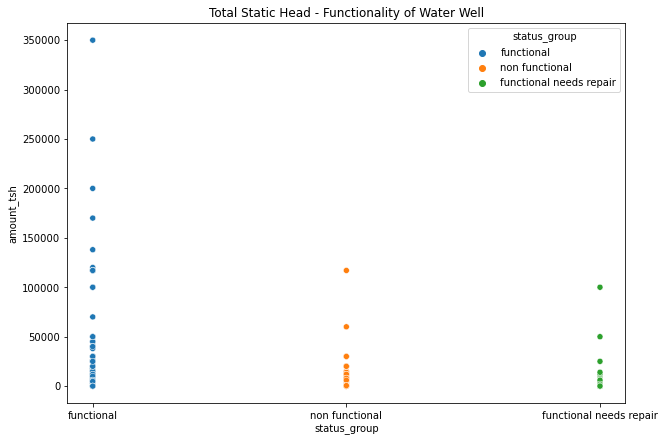

In [20]:
#plotting the relationship between the highest positively correlated values and the target 
plt.figure(figsize=(10,7))
sns.scatterplot(data= df1, x='status_group', y='amount_tsh', hue='status_group')
plt.title('Total Static Head - Functionality of Water Well');

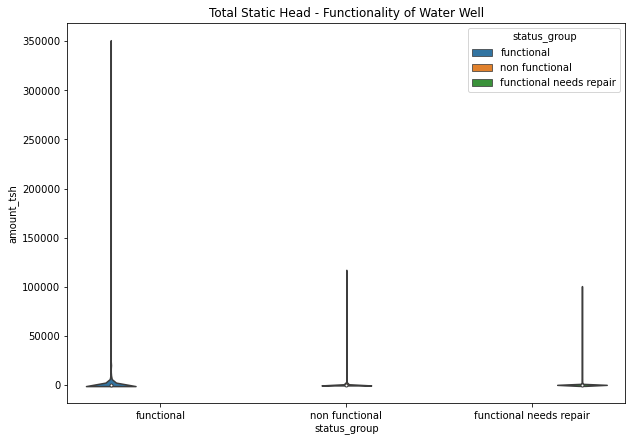

In [170]:
# violin plot
plt.figure(figsize=(10,7))
sns.violinplot(data= df, x='status_group', y='amount_tsh', hue='status_group')
plt.title('Total Static Head - Functionality of Water Well');

In [22]:
#displaying the value counts of funder and installer 
print('--funder--')
display(df['funder'].value_counts())

print('--installer--')
display(df['installer'].value_counts())

--funder--


Government Of Tanzania     9084
Danida                     3114
Hesawa                     2202
Rwssp                      1374
World Bank                 1349
                           ... 
Islamic Society               1
Compasion International       1
Iado                          1
Samweli                       1
Hery                          1
Name: funder, Length: 1897, dtype: int64

--installer--


DWE                   17402
Government             1825
RWE                    1206
Commu                  1060
DANIDA                 1050
                      ...  
Ta                        1
British government        1
Swalehe Rajabu            1
Tajiri Jumbe Lila         1
Morovi                    1
Name: installer, Length: 2145, dtype: int64

`funder` and `installer` have some similarities but are different enough to want to keep them both for visualizations. However, will most likely not keep in the final dataset used because there are too many unique values. 1897 unique values for `funder` and 2145 for `installer`.

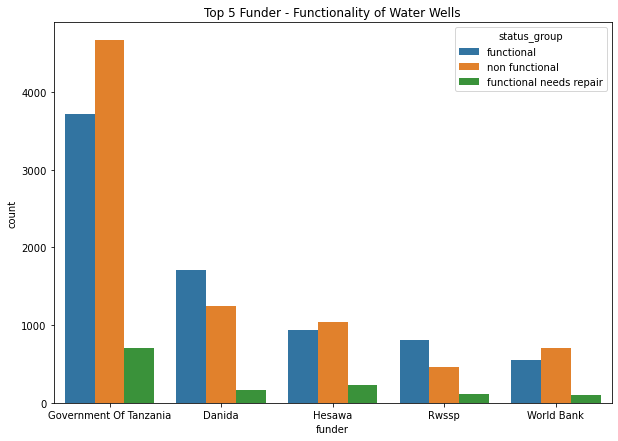

In [23]:
#plotting the relationship with the top 5 funder groups and status group  
plt.figure(figsize=(10,7))
sns.countplot(data=df, x='funder', hue='status_group', order=df.funder.value_counts().iloc[:5].index)
plt.title('Top 5 Funder - Functionality of Water Wells');

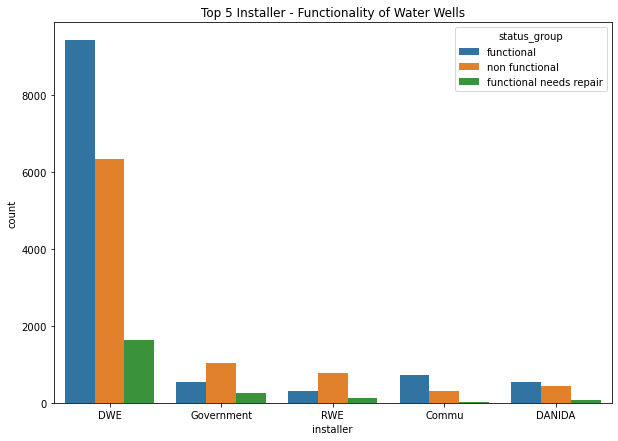

In [24]:
#plotting the relationship with the top 5 installer groups and status group  
plt.figure(figsize=(10,7))
sns.countplot(data=df, x='installer', hue='status_group', order=df.installer.value_counts().iloc[:5].index)
plt.title('Top 5 Installer - Functionality of Water Wells');

The top `funder` and the top `installer` are the ones that have the most functional, non functional, and functional needs repair.

In [26]:
#checking the values of gps_height
df['gps_height'].value_counts()

 0       20438
-15         60
-16         55
-13         55
-20         52
         ...  
 2285        1
 2424        1
 2552        1
 2413        1
 2385        1
Name: gps_height, Length: 2428, dtype: int64

Most of the values in `gps_height` are 0 this could mean that this at sea level so there are not many alarm bells ringing right now.

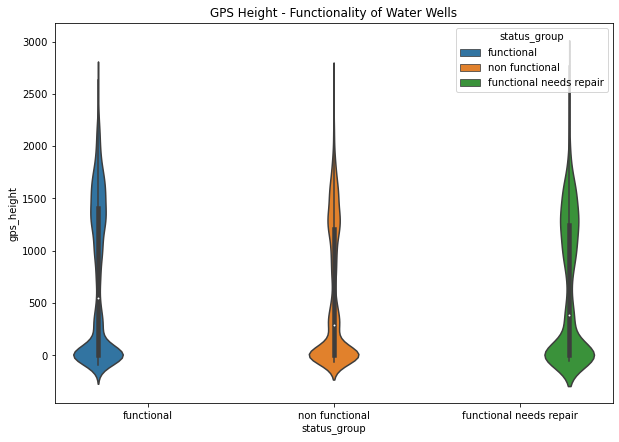

In [27]:
plt.figure(figsize=(10,7))
sns.violinplot(data=df, x='status_group', y='gps_height', hue='status_group')
plt.title('GPS Height - Functionality of Water Wells');

Looking at the violin plot can see that there is more range with `gps_height` in the functional needs repair status group. The medians are fairly similar with functional being slightly further up. There is also more frequency in functional needs repair.

In [28]:
#displaying the value counts of longitude and latitude
print('--longitude--')
display(df['longitude'].value_counts())

print('--latitude--')
display(df['latitude'].value_counts())

--longitude--


0.000000     1812
39.088875       2
39.105307       2
37.543401       2
38.180538       2
             ... 
38.710520       1
40.117029       1
34.672962       1
39.433604       1
34.890838       1
Name: longitude, Length: 57516, dtype: int64

--latitude--


-2.000000e-08    1812
-6.990549e+00       2
-2.489378e+00       2
-2.515321e+00       2
-6.963565e+00       2
                 ... 
-1.086099e+01       1
-3.149066e+00       1
-3.305834e+00       1
-9.076967e+00       1
-2.598965e+00       1
Name: latitude, Length: 57517, dtype: int64

Can see that there are placeholder value in `longitude` - 0.000000 and `latitude` - -2.000000e-08. We will drop this rows since there are 1812 values that are missing. Only 0.03% of the dataset.

In [29]:
#dropping those values from the df
df = df[df['longitude'] != 0.000000]
df = df[df['latitude'] != -2.000000e-08]

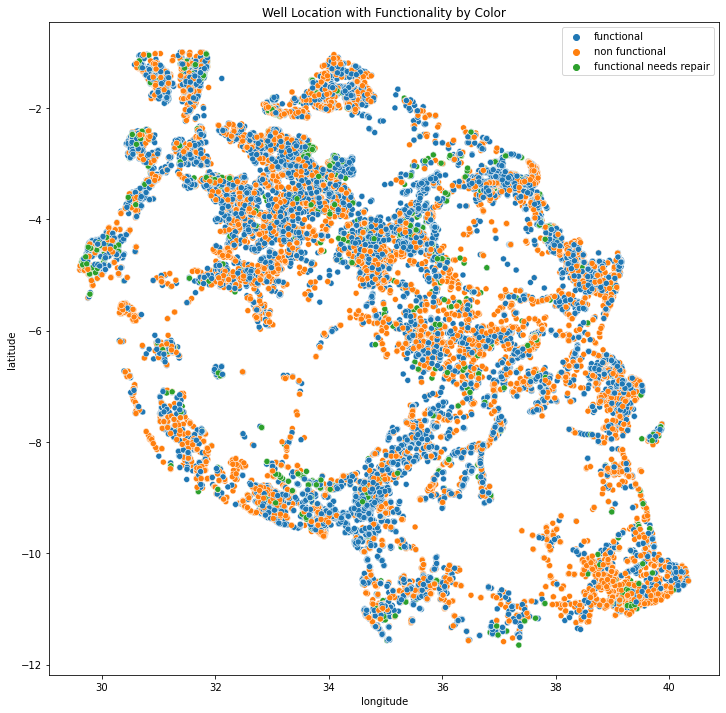

In [30]:
# Heat Map
fig, ax = plt.subplots(figsize=(12,12))

sns.scatterplot(x='longitude', y='latitude', hue='status_group', data=df, ax=ax)
plt.title('Well Location with Functionality by Color')
plt.legend(fancybox=True);

There isn't a very clear relationship between the `longitude` and `latitude` of the wells and their functionality. There is a more clustering of well (no matter their functionality) where ther are bigger cities in Tanzania. There are more 'non functional' wells in the south eastern part of the country.

In [31]:
#displaying the value counts of wpt_name
df['wpt_name'].value_counts()

none                   3492
Shuleni                1734
Zahanati                814
Msikitini               533
Kanisani                322
                       ... 
Konde                     1
Kwa Mtimanyongo           1
Lobo Wildlife Lodge       1
Christopher Rashid        1
Kwa Mariamu Nyato         1
Name: wpt_name, Length: 36720, dtype: int64

The `wpt_name` doesn't really give much value to the modeling nor the EDA since these are just the names of the waterpoint. Will also drop `num_private` from the dataframe since it has no meaning in the data dictionary.

In [32]:
#displaying the value counts of basin 
df['basin'].value_counts()

Pangani                    8940
Lake Victoria              8535
Rufiji                     7976
Internal                   7785
Lake Tanganyika            6333
Wami / Ruvu                5987
Lake Nyasa                 5085
Ruvuma / Southern Coast    4493
Lake Rukwa                 2454
Name: basin, dtype: int64

Want to keep this since it can be mapped for the modeling and can also make for good EDA.

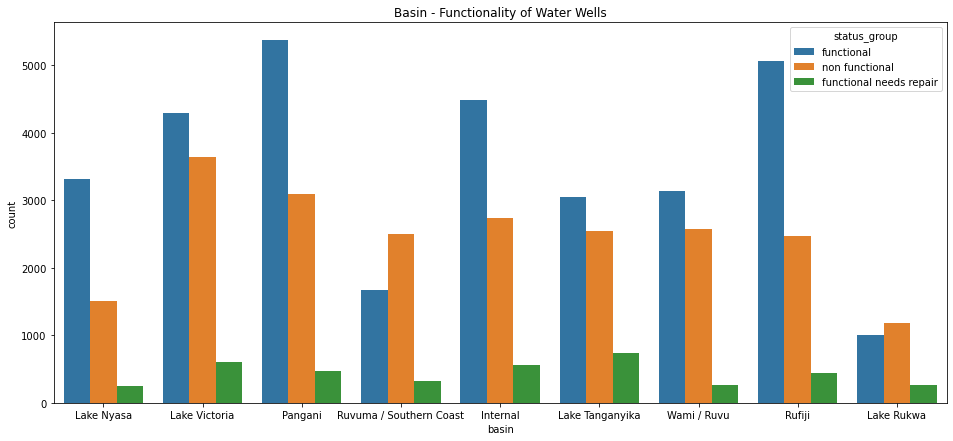

In [33]:
plt.figure(figsize=(16,7))
sns.countplot(data=df, x='basin', hue='status_group')
plt.title('Basin - Functionality of Water Wells');

From this chart can see that the `basin` Pangani has the most 'functional' wells with Rufiji coming in close second. Lake Victoria has the most 'non functiional' wells with Pangani coming in second. Lake Tanganyika has the most 'functional needs repair' wells with Lake Victoria coming second. The basins that have the more 'non functional' well to 'functional' wells are Lake Rukwa and Ruvuma/Southern Coast.

In [34]:
#displaying the value counts of subvillage
df['subvillage'].value_counts()

Majengo       494
Shuleni       492
Madukani      435
Kati          366
Mtakuja       257
             ... 
Lubisu B        1
Mwakisabu       1
Tandamize       1
Loleza A        1
Mwakusamka      1
Name: subvillage, Length: 18567, dtype: int64

There are 18,567 unique values in `subvillage` not useful for modeling but can tell us something interesting in EDA. In the plot below will display the top 5 subvillages.

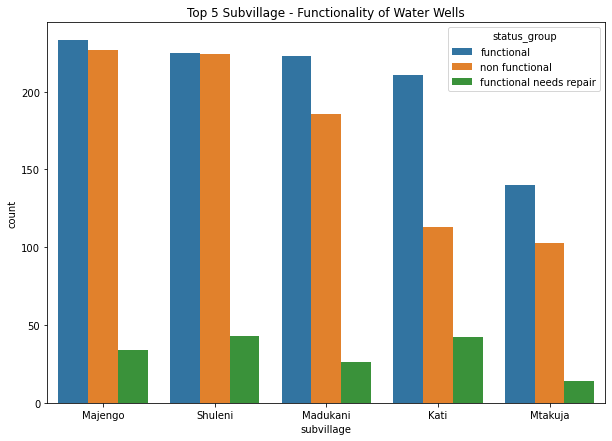

In [35]:
#plotting the relationship with the top 5 subvillages and status group  
plt.figure(figsize=(10,7))
sns.countplot(data=df, x='subvillage', hue='status_group', order=df.subvillage.value_counts().iloc[:5].index)
plt.title('Top 5 Subvillage - Functionality of Water Wells');

The `subvillage` with the most 'functional' wells also have the most 'non functional' wells. The subvillage Kati has the better ratio between 'functional', 'non functional', and 'functional needs repair'. 

In [36]:
#displaying the value counts of region 
df['region'].value_counts()

Iringa           5294
Mbeya            4639
Kilimanjaro      4379
Morogoro         4006
Shinyanga        3977
Arusha           3350
Kagera           3316
Kigoma           2816
Ruvuma           2640
Pwani            2635
Tanga            2547
Mwanza           2295
Dodoma           2201
Singida          2093
Mara             1969
Tabora           1959
Rukwa            1808
Mtwara           1730
Manyara          1583
Lindi            1546
Dar es Salaam     805
Name: region, dtype: int64

Want to keep this since it can be mapped for the modeling and can also make for good EDA.

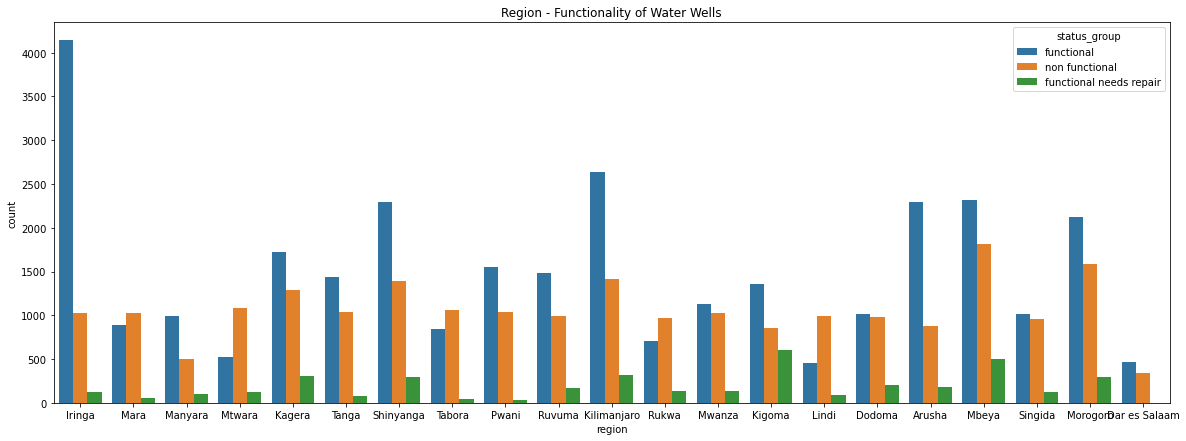

In [37]:
plt.figure(figsize=(20,7))
sns.countplot(data=df, x='region', hue='status_group')
plt.title('Region - Functionality of Water Wells');

Can see from this chart that the `region` Iringa has an overwhelmingly amount of the 'functional' wells with over 4000 of them. The region Kilmanjaro comes in second with a little under 3000. The region with with most 'non functional' wells is Mbeya with 1800. The region Kigoma has the most 'functional needs repair' wells around 700. 

In [38]:
#displaying the value counts of region_code and district_code
print('--region code--')
display(df['region_code'].value_counts())

print('--district code--')
display(df['district_code'].value_counts())

--region code--


11    5297
12    4639
3     4379
5     4040
17    3954
18    3324
2     3024
16    2816
10    2640
4     2513
19    2295
1     2201
13    2093
14    1979
20    1969
15    1808
6     1609
21    1583
80    1238
60    1025
90     917
7      805
99     423
9      390
24     326
8      300
40       1
Name: region_code, dtype: int64

--district code--


1     11146
2     10909
3      9998
4      8996
5      4356
6      3586
7      3343
8      1043
30      995
33      874
53      745
43      505
13      391
23      293
63      195
62      109
60       63
0        23
80       12
67        6
Name: district_code, dtype: int64

Will not keep this features since we do not which region and district are where with the code in the model but will make for interesting EDA will see the top 10 of each.

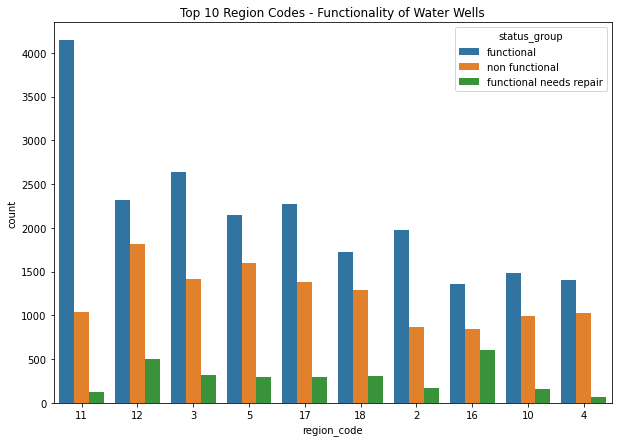

In [39]:
#plotting the relationship with the top 10 region_code and status group  
plt.figure(figsize=(10,7))
sns.countplot(data=df, x='region_code', hue='status_group', order=df.region_code.value_counts().iloc[:10].index)
plt.title('Top 10 Region Codes - Functionality of Water Wells');

`region_code` 11 has more 'functional' wells with a little bit over 4000. This matches with `region` Iringa. The region_code 3 comes in second with a little over 2500. The region_code with the most 'non functional' wells is 12 around 1800 which matches the region Mbeya. The one with the most 'functional needs repair' wells is 16 with 700 which matches with Kigoma.

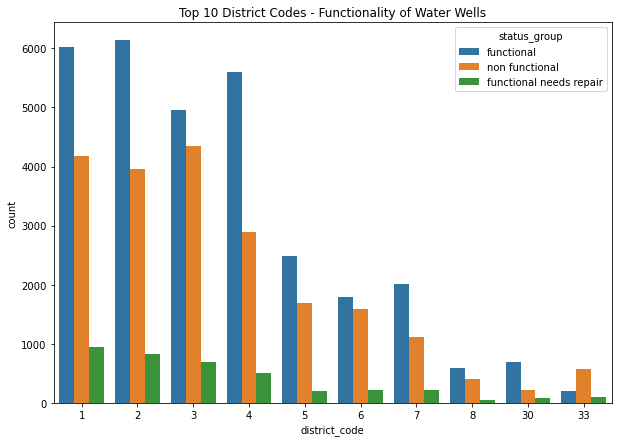

In [40]:
#plotting the relationship with the top 10 distict_code and status group  
plt.figure(figsize=(10,7))
sns.countplot(data=df, x='district_code', hue='status_group', order=df.district_code.value_counts().iloc[:10].index)
plt.title('Top 10 District Codes - Functionality of Water Wells');

`distict_code` 2 has more 'functional' wells with a little bit over 6000. The district code 1 coming in close second at 6000. The district_code with the most 'non functional' wells is 3 around 4500. The one with the most 'functional needs repair' wells is 1 with little under a 1000.

In [42]:
#displaying the value counts of lga and ward - geographic location
print('--lga--')
display(df['lga'].value_counts())

print('--ward--')
display(df['ward'].value_counts())

--lga--


Njombe          2503
Arusha Rural    1252
Moshi Rural     1251
Rungwe          1106
Kilosa          1094
                ... 
Moshi Urban       79
Kigoma Urban      71
Arusha Urban      63
Lindi Urban       21
Nyamagana          1
Name: lga, Length: 124, dtype: int64

--ward--


Igosi              307
Imalinyi           252
Siha Kati          232
Mdandu             231
Nduruma            217
                  ... 
Kinungu              1
Kitete               1
Burungura            1
Uwanja wa Ndege      1
Nsemulwa             1
Name: ward, Length: 2033, dtype: int64

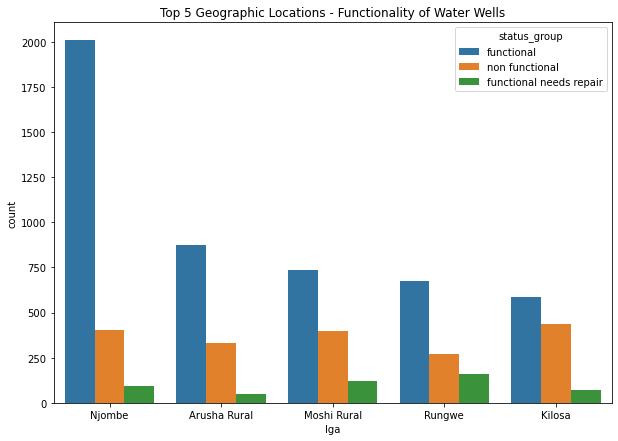

In [43]:
#plotting the relationship with the top 5 lga and status group  
plt.figure(figsize=(10,7))
sns.countplot(data=df, x='lga', hue='status_group', order=df.lga.value_counts().iloc[:5].index)
plt.title('Top 5 Geographic Locations - Functionality of Water Wells');

An overwhelming amount of 'functional' wells in Njombe. The location with the most 'non functional' wells are Kilosa and the one with the most 'functional needs repair' is Rungwe.

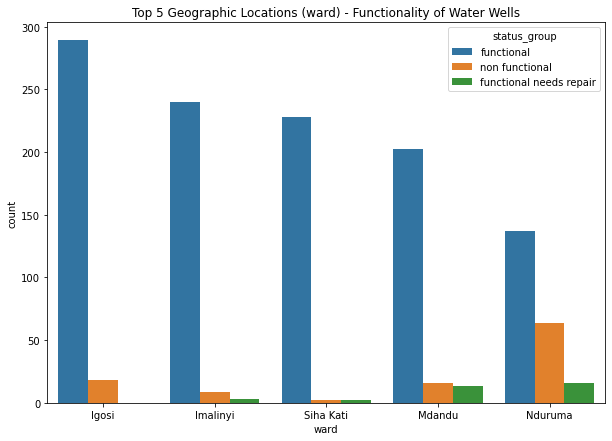

In [44]:
#plotting the relationship with the top 5 lga and status group  
plt.figure(figsize=(10,7))
sns.countplot(data=df, x='ward', hue='status_group', order=df.ward.value_counts().iloc[:5].index)
plt.title('Top 5 Geographic Locations (ward) - Functionality of Water Wells');

This is an interesting graph since there are not many 'non functional' and 'functional needs repair' in these geographic locations. Could be that there are more non functional wells in different `ward` but there are too many unique values.

In [45]:
#displaying the value counts of population 
df['population'].value_counts()

0       19569
1        7025
200      1940
150      1892
250      1681
        ...  
3241        1
1960        1
1685        1
2248        1
1439        1
Name: population, Length: 1049, dtype: int64

There are many 0 values but this could mean that wells are far off from Tanzania residents. Let's take a further look.

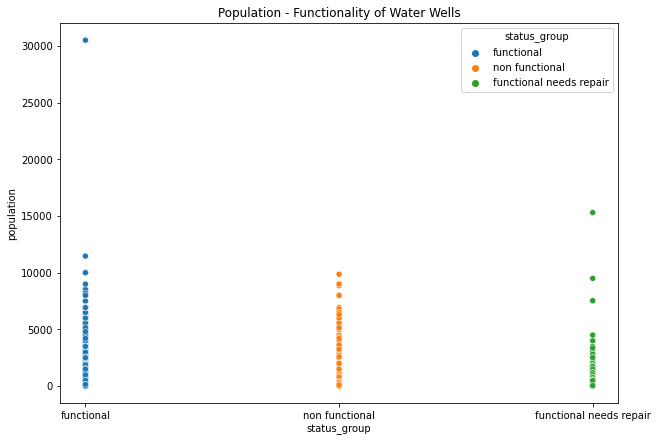

In [46]:
plt.figure(figsize=(10,7))
sns.scatterplot(data=df, x='status_group', y='population', hue='status_group')
plt.title('Population - Functionality of Water Wells');

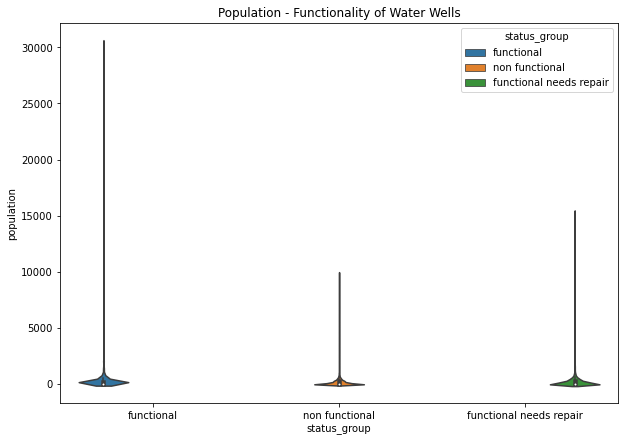

In [47]:
plt.figure(figsize=(10,7))
sns.violinplot(data=df, x='status_group', y='population', hue='status_group')
plt.title('Population - Functionality of Water Wells');

These graphs don't tell us much since there were so many values equal to 0 but can see there is a larger range in 'functional' wells.

In [48]:
#displaying the value counts of permit 
df['public_meeting'].value_counts()

True     49737
False     4875
Name: public_meeting, dtype: int64

There are some null values. Will not use in modeling but let's plot it to see its relationship with well functionality

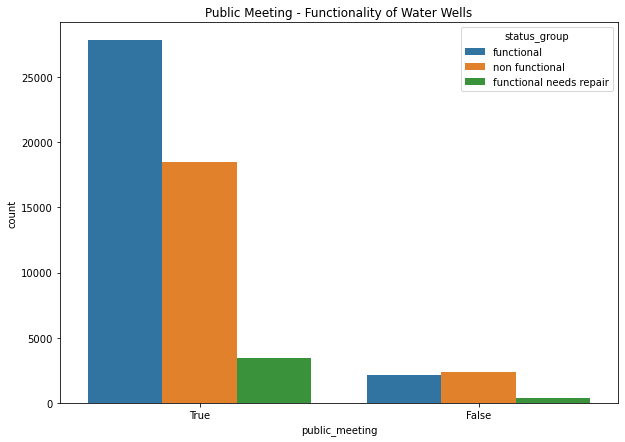

In [49]:
plt.figure(figsize=(10,7))
sns.countplot(data=df, x='public_meeting', hue='status_group')
plt.title('Public Meeting - Functionality of Water Wells');

The relationship between `public_meeting` and functionality seems like if there is a public meeting the more known about the functionality of the well which makes sense. This is not very insightful for modeling so will drop.

In [50]:
#displaying the value counts of scheme_name 
df['scheme_name'].value_counts()

K                          682
None                       644
Borehole                   418
Chalinze wate              405
M                          400
                          ... 
Magati  gravity spri         1
LANCH                        1
Mkeyui streem                1
Kigondo                      1
Imalampaka water supply      1
Name: scheme_name, Length: 2658, dtype: int64

Will not keep this feature since there are too many missing values and `scheme_management` according to the data dictionary has the same values.

In [51]:
#displaying the value counts of scheme_management 
df['scheme_management'].value_counts()

VWC                 36143
WUG                  4249
Water authority      3151
WUA                  2882
Water Board          2747
Parastatal           1607
Private operator     1063
Company              1061
Other                 765
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64

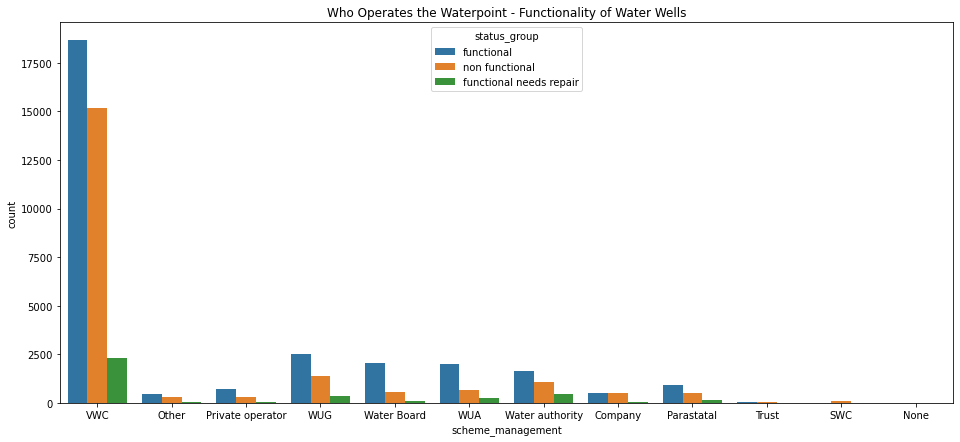

In [52]:
plt.figure(figsize=(16,7))
sns.countplot(data=df, x='scheme_management', hue='status_group')
plt.title('Who Operates the Waterpoint - Functionality of Water Wells');

WWC overwhelmingly operates the waterpoints but this doesn't tell us much since it operates more than it will also have the most 'functional', 'non functional', and 'functional needs repair'.

In [53]:
#displaying the value counts of permit 
df['permit'].value_counts()

True     38100
False    16432
Name: permit, dtype: int64

There is a good amount of values which are null in permit but seems like a very telling feature will keep and see how it relates with status groups

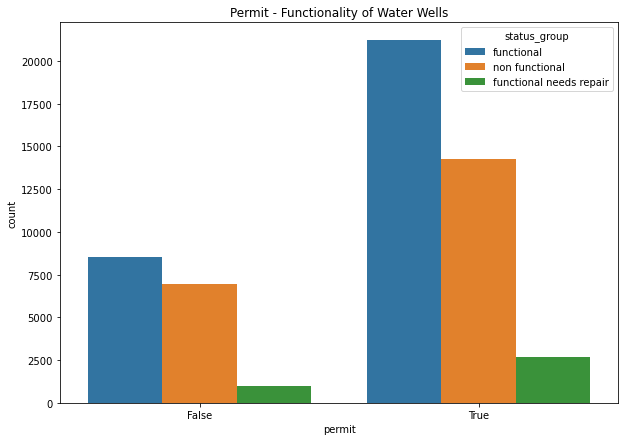

In [54]:
plt.figure(figsize=(10,7))
sns.countplot(data=df, x='permit', hue='status_group')
plt.title('Permit - Functionality of Water Wells');

If the waterpoint is permitted the wells tend to be more 'functional'. There is more of gap between the 'functional' and 'non functional' wells when the permit is equal to true. This could be a good indicator as to the functionality of the wells.

In [55]:
#displaying the value counts of construction_year 
df['construction_year'].value_counts()

0       18897
2010     2645
2008     2613
2009     2533
2000     2091
2007     1587
2006     1471
2003     1286
2011     1256
2004     1123
2012     1084
2002     1075
1978     1037
1995     1014
2005     1011
1999      979
1998      966
1990      954
1985      945
1980      811
1996      811
1984      779
1982      744
1994      738
1972      708
1974      676
1997      644
1992      640
1993      608
2001      540
1988      521
1983      488
1975      437
1986      434
1976      414
1970      411
1991      324
1989      316
1987      302
1981      238
1977      202
1979      192
1973      184
2013      176
1971      145
1960      102
1967       88
1963       85
1968       77
1969       59
1964       40
1962       30
1961       21
1965       19
1966       17
Name: construction_year, dtype: int64

There are a lot of zeros will take the median to impute these values but will have to do this later. Let's look at the top 10 disregarding the 0.

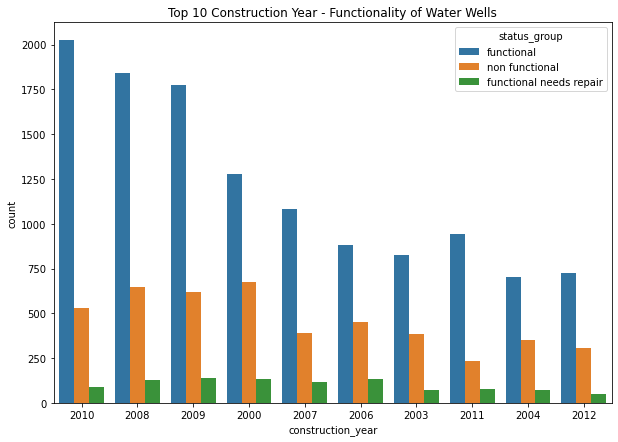

In [56]:
#plotting the relationship with the top 5 lga and status group  
plt.figure(figsize=(10,7))
sns.countplot(data=df, x='construction_year', hue='status_group', order=df.construction_year.value_counts().iloc[1:11].index)
plt.title('Top 10 Construction Year - Functionality of Water Wells');

The wells that are more functional are the ones that were constructed within the years of 2009 through 2010. They have the better ratio of 'non functional' and 'functional needs repair' as well. The year with the least 'functional'wells is 2004.

In [57]:
#displaying the value counts of extraction_type, extraction_type_group and extraction_type_class 
print('--extraction_type--')
display(df['extraction_type'].value_counts())

print('--extraction_type_group--')
display(df['extraction_type_group'].value_counts())

print('--extraction_type_class--')
display(df['extraction_type_class'].value_counts())

--extraction_type--


gravity                      26696
nira/tanira                   7361
other                         6160
submersible                   4688
swn 80                        3448
mono                          2817
india mark ii                 2284
afridev                       1659
ksb                           1358
other - rope pump              451
other - swn 81                 229
windmill                       117
india mark iii                  91
cemo                            90
other - play pump               85
climax                          32
walimi                          20
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64

--extraction_type_group--


gravity            26696
nira/tanira         7361
other               6160
submersible         6046
swn 80              3448
mono                2817
india mark ii       2284
afridev             1659
rope pump            451
other handpump       336
other motorpump      122
wind-powered         117
india mark iii        91
Name: extraction_type_group, dtype: int64

--extraction_type_class--


gravity         26696
handpump        15179
other            6160
submersible      6046
motorpump        2939
rope pump         451
wind-powered      117
Name: extraction_type_class, dtype: int64

These features `extraction_type`, `extraction_type_group`, `extraction_type_class` are the same just less specific as you go down. We decided it was best to use `extraction_type_class` as to not have too many columns when OneHotEncoding.

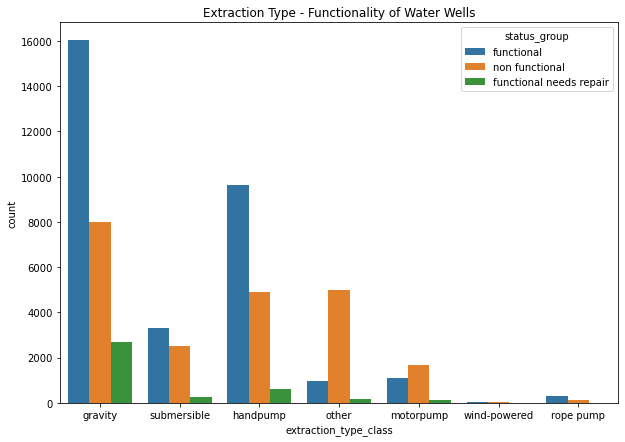

In [59]:
plt.figure(figsize=(10,7))
sns.countplot(data=df, x='extraction_type_class', hue='status_group')
plt.title('Extraction Type - Functionality of Water Wells');

The kind of extraction the waterpoint uses, `extraction_type_class`, that has the most 'functional' wells is gravity at 16,000. It has a good amount 'non functional' wells but it has a better ratio of the functionality of the wells than handpump which has the second most 'functional wells' at 10,000.

In [60]:
#displaying the value counts of management, and management_group 
print('--management--')
display(df['management'].value_counts())

print('--management_group--')
display(df['management_group'].value_counts())

--management--


vwc                 39746
wug                  5556
water board          2932
wua                  2533
private operator     1970
parastatal           1696
water authority       902
other                 840
company               685
unknown               551
other - school         99
trust                  78
Name: management, dtype: int64

--management_group--


user-group    50767
commercial     3635
parastatal     1696
other           939
unknown         551
Name: management_group, dtype: int64

Will keep management since it has a better breakdown of the management. Will also drop scheme_management since it has the same values as it but it is not as specific. Management is a happy medium.

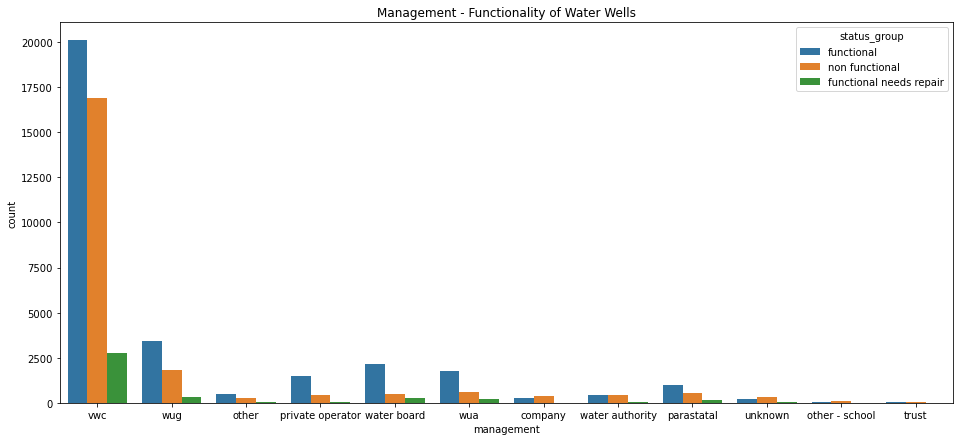

In [61]:
plt.figure(figsize=(16,7))
sns.countplot(data=df, x='management', hue='status_group')
plt.title('Management - Functionality of Water Wells');

The `management` value wwc manages the most wells so it makes sense that it has the most 'functional', 'non functional', and 'functional needs repair' wells. This doesn't really give us groundbreaking information but might be useful to keep and is the better of the other two which give the same information.

In [62]:
#displaying the value counts of payment, and payment_type 
print('--payment--')
display(df['payment'].value_counts())

print('--payment_type--')
display(df['payment_type'].value_counts())

--payment--


never pay                24380
pay per bucket            8953
pay monthly               8229
unknown                   7654
pay when scheme fails     3843
pay annually              3626
other                      903
Name: payment, dtype: int64

--payment_type--


never pay     24380
per bucket     8953
monthly        8229
unknown        7654
on failure     3843
annually       3626
other           903
Name: payment_type, dtype: int64

They features have the same value but we decided to keep the `payment_type` just since it is more succint in the wording of its values.

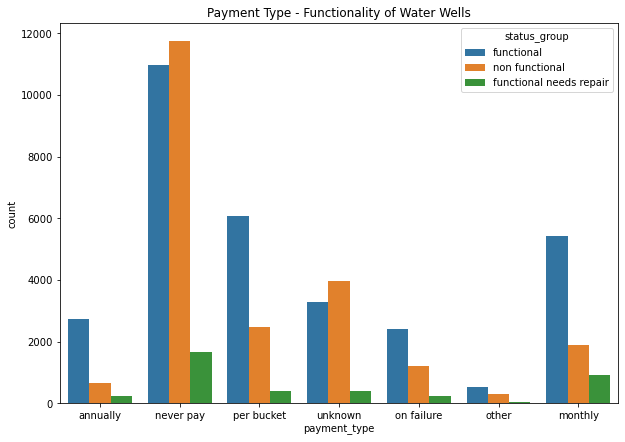

In [63]:
plt.figure(figsize=(10,7))
sns.countplot(data=df, x='payment_type', hue='status_group')
plt.title('Payment Type - Functionality of Water Wells');

The `payment_type` value has never pay has the most the 'functional', 'non functional', and 'functional needs repair' wells with 'non functional' surpassing the 'functional' wells with as little under 12,000. The `payment_type` per bucket and monthly have the better ratios with the functionality of the wells.

In [64]:
#displaying the value counts of water_quality, and quality_group
print('--water_quality--')
display(df['water_quality'].value_counts())

print('--quality_group--')
display(df['quality_group'].value_counts())

--water_quality--


soft                  49431
salty                  4772
unknown                1661
milky                   803
coloured                479
salty abandoned         228
fluoride                199
fluoride abandoned       15
Name: water_quality, dtype: int64

--quality_group--


good        49431
salty        5000
unknown      1661
milky         803
colored       479
fluoride      214
Name: quality_group, dtype: int64

Since the feature are the same and basically have the same values then we are going with `quality_group` since it has a pretty good breakdown of the water quality although not as many as `water_quality`. Those values don't have too many values.

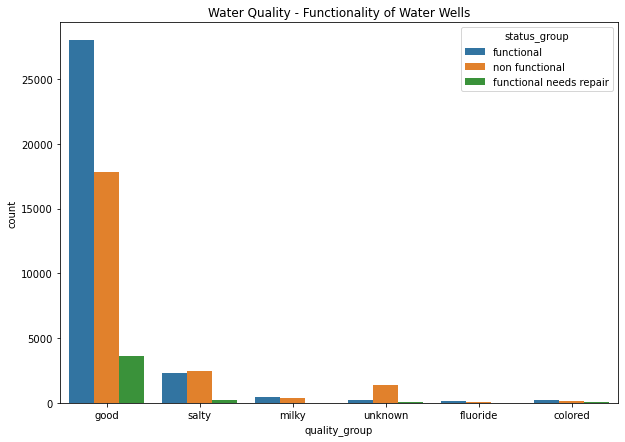

In [66]:
plt.figure(figsize=(10,7))
sns.countplot(data=df, x='quality_group', hue='status_group')
plt.title('Water Quality - Functionality of Water Wells');

There are more of the good values for `quality_groups` with 'functional', 'non functional', and 'functional needs repair' wells.

In [67]:
#displaying the value counts of quantity, and quantity_group
print('--quantity--')
display(df['quantity'].value_counts())

print('--quantity_group--')
display(df['quantity_group'].value_counts())

--quantity--


enough          32260
insufficient    14564
dry              5990
seasonal         4001
unknown           773
Name: quantity, dtype: int64

--quantity_group--


enough          32260
insufficient    14564
dry              5990
seasonal         4001
unknown           773
Name: quantity_group, dtype: int64

The features have the same values will just arbritarily keep `quanitity` and drop the other.

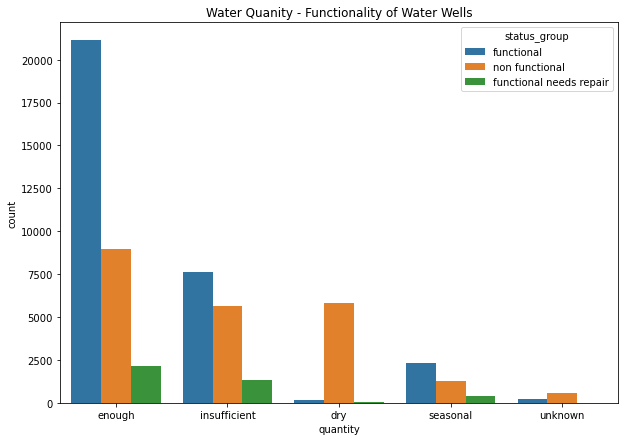

In [68]:
plt.figure(figsize=(10,7))
sns.countplot(data=df, x='quantity', hue='status_group')
plt.title('Water Quanity - Functionality of Water Wells');

The `quantity` value enough has most 'functional', 'non functional', and 'functional needs repair' wells; however, it has better ratio with the functionality unlike insufficient and dry which makes sense why their status group would be overwhelmingly 'non functional'

In [69]:
#displaying the value counts of source, source_type and source_class 
print('--source--')
display(df['source'].value_counts())

print('--source_type--')
display(df['source_type'].value_counts())

print('--source_class--')
display(df['source_class'].value_counts())

--source--


spring                  17006
shallow well            15499
machine dbh             10826
river                    9612
rainwater harvesting     2218
hand dtw                  873
dam                       649
lake                      639
other                     202
unknown                    64
Name: source, dtype: int64

--source_type--


spring                  17006
shallow well            15499
borehole                11699
river/lake              10251
rainwater harvesting     2218
dam                       649
other                     266
Name: source_type, dtype: int64

--source_class--


groundwater    44204
surface        13118
unknown          266
Name: source_class, dtype: int64

Will keep `source_type` since it is a happy medium between `source` which is too specific and `source_class` which isn't specific enough.

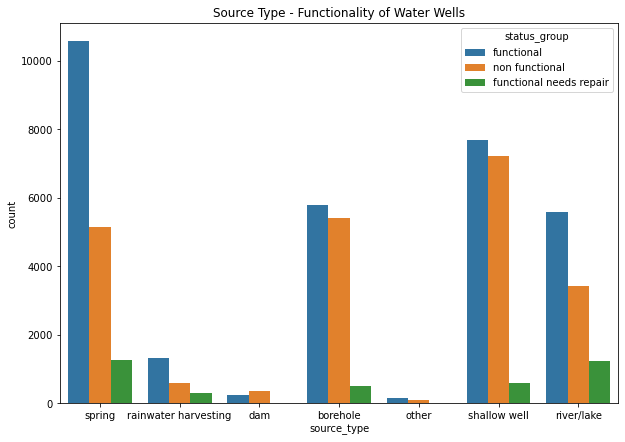

In [70]:
plt.figure(figsize=(10,7))
sns.countplot(data=df, x='source_type', hue='status_group')
plt.title('Source Type - Functionality of Water Wells');

The `source_type` with the most 'functional' wells is spring with more than 10,000 wells. Shallow wells comes in second with a little under 8000 wells. Shallow wells also has the most 'non functional' wells at 7800 with borehole coming in second. The source of the water river/lake has the most 'functional needs repair' wells with spring coming in second.

In [71]:
#displaying the value counts of waterpoint_type, and waterpoint_type_group 
print('--waterpoint_type--')
display(df['waterpoint_type'].value_counts())

print('--waterpoint_type_group--')
display(df['waterpoint_type_group'].value_counts())

--waterpoint_type--


communal standpipe             28375
hand pump                      16181
other                           6167
communal standpipe multiple     5959
improved spring                  783
cattle trough                    116
dam                                7
Name: waterpoint_type, dtype: int64

--waterpoint_type_group--


communal standpipe    34334
hand pump             16181
other                  6167
improved spring         783
cattle trough           116
dam                       7
Name: waterpoint_type_group, dtype: int64

We decided to keep `waterpoint_type` instead of `waterpoint_type_group` because we preferred the specificity it provided especially since there are a significant amount of values in difference between values communal standpipe and communal standpipe multiple.

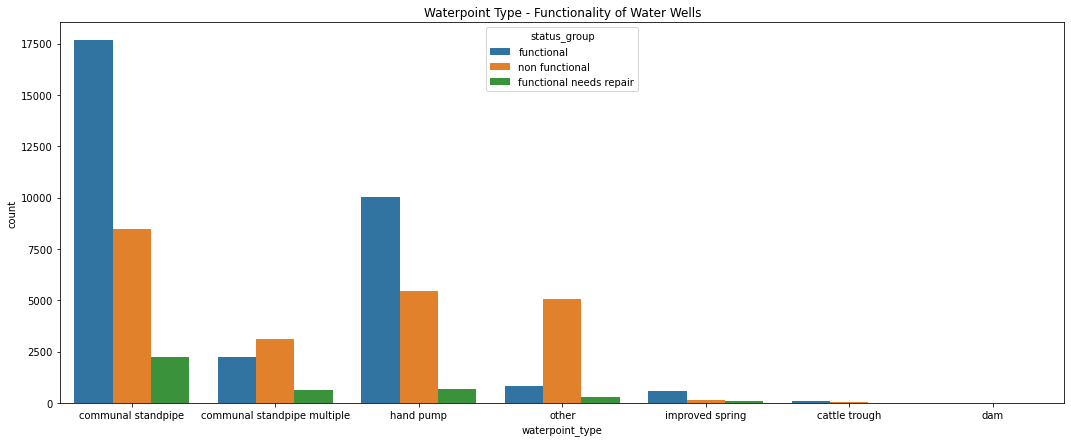

In [72]:
plt.figure(figsize=(18,7))
sns.countplot(data=df, x='waterpoint_type', hue='status_group')
plt.title('Waterpoint Type - Functionality of Water Wells');

Can see from this chart that the value communal standpipe has the most 'functional' wells at 17,500 with hand pump coming in second at over 10,000. The communal standpipe also has the most 'non-functional' wells with (once again) hand pump coming in second.

In [73]:
#dropping columns that we do not need
df2 = df.drop(columns=['scheme_name', 'date_recorded', 'wpt_name', 'num_private', 'region_code', 'district_code', 
                                'public_meeting', 'recorded_by', 'extraction_type', 'extraction_type_group','management_group', 
                                'payment', 'water_quality', 'quantity_group', 'source', 'source_class', 'waterpoint_type_group',
                                'scheme_management']
                       , axis=1)

In [74]:
# Check new data set
df2.head()

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,basin,subvillage,region,...,permit,construction_year,extraction_type_class,management,payment_type,quality_group,quantity,source_type,waterpoint_type,status_group
0,69572,6000.0,Roman,1390,Roman,34.938093,-9.856322,Lake Nyasa,Mnyusi B,Iringa,...,False,1999,gravity,vwc,annually,good,enough,spring,communal standpipe,functional
1,8776,0.0,Grumeti,1399,GRUMETI,34.698766,-2.147466,Lake Victoria,Nyamara,Mara,...,True,2010,gravity,wug,never pay,good,insufficient,rainwater harvesting,communal standpipe,functional
2,34310,25.0,Lottery Club,686,World vision,37.460664,-3.821329,Pangani,Majengo,Manyara,...,True,2009,gravity,vwc,per bucket,good,enough,dam,communal standpipe multiple,functional
3,67743,0.0,Unicef,263,UNICEF,38.486161,-11.155298,Ruvuma / Southern Coast,Mahakamani,Mtwara,...,True,1986,submersible,vwc,never pay,good,dry,borehole,communal standpipe multiple,non functional
4,19728,0.0,Action In A,0,Artisan,31.130847,-1.825359,Lake Victoria,Kyanyamisa,Kagera,...,True,0,gravity,other,never pay,good,seasonal,rainwater harvesting,communal standpipe,functional


In [75]:
# Sanity check
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57588 entries, 0 to 59399
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     57588 non-null  int64  
 1   amount_tsh             57588 non-null  float64
 2   funder                 53966 non-null  object 
 3   gps_height             57588 non-null  int64  
 4   installer              53952 non-null  object 
 5   longitude              57588 non-null  float64
 6   latitude               57588 non-null  float64
 7   basin                  57588 non-null  object 
 8   subvillage             57217 non-null  object 
 9   region                 57588 non-null  object 
 10  lga                    57588 non-null  object 
 11  ward                   57588 non-null  object 
 12  population             57588 non-null  int64  
 13  permit                 54532 non-null  object 
 14  construction_year      57588 non-null  int64  
 15  ex

## Mapping categorical values to numeric categorical values.

We will now convert our categorical values to numeric categorical values so that our models will work with the data in a way that will hopefully lead to better model performance.

In [76]:
# Numeration of our target status group
status_group_map = {'functional': 0, 'non functional': 1, 'functional needs repair': 1}
df2['status_group_num'] = df2['status_group'].map(status_group_map)

In [77]:
# Numeration of payment_type
payment_num = {'never pay': 0, 'per bucket': 1, 'monthly': 2, 'unknown': 3, 
                               'on failure': 4, 'annually': 5, 'other': 6}
df2['payment_num'] = df2['payment_type'].map(payment_num)

In [78]:
# Numeration of management
management_num = {'vwc': 0, 'wug': 1, 'water board': 2, 'wua': 3, 'private operator': 4, 
              'parastatal': 5, 'water authority': 6, 'other':7, 'company': 8, 
              'unknown':9, 'other - school':10, 'trust':11}
df2['management_num'] = df2['management'].map(management_num)

In [79]:
#mapping basin map
basin_map = {'Lake Victoria': 0,
             'Pangani': 1,
             'Rufiji': 2,
             'Internal': 3,
             'Lake Tanganyika': 4,
             'Wami / Ruvu': 5,
             'Lake Nyasa': 6,
             'Ruvuma / Southern Coast': 7,
             'Lake Rukwa': 8}

#adding in to df2
df2['basin_num'] = df2['basin'].map(basin_map)

In [80]:
# Numeration of quality_group
quality_group_map = {'good':1, 'salty':2, 'unknown':3, 'milky':4, 'colored':5, 'fluoride':6}
df2['qualtiy_group_num'] = df2['quality_group'].map(quality_group_map)

In [81]:
# Numeration of quantity
quantity_map = {'enough':0, 'insufficient':1, 'dry':2, 'seasonal':3, 'unknown':4}
df2['quantity_num'] = df2['quantity'].map(quantity_map)

In [82]:
# Numeration of source_type
source_type_num = {'spring':0, 'shallow well':1, 'borehole':2, 'river/lake':3, 'rainwater harvesting':4, 'dam':5, 'other':6}
df2['source_type_num'] = df2['source_type'].map(source_type_num)

In [83]:
# Numeration of waterpoint_type
waterpoint_type_map = {'communal standpipe':0, 'hand pump':1, 'other':2, 'communal standpipe multiple':3, 
                       'improved spring':4, 'cattle trough':5, 'dam':6}
df2['waterpoint_type_num'] = df2['waterpoint_type'].map(waterpoint_type_map)

In [84]:
# Numeration of region 
region_map = {'Iringa': 0,
             'Shinyanga': 1,
             'Mbeya': 2,
             'Kilimanjaro': 3,
             'Morogoro': 4,
             'Arusha': 5,
             'Kagera': 6,
             'Mwanza': 7,
             'Kigoma': 8,
             'Ruvuma': 9, 
             'Pwani': 10,
             'Tanga': 11,
             'Dodoma': 12,
             'Singida': 13,
             'Mara': 14,
             'Tabora': 15,
             'Rukwa': 16, 
             'Mtwara': 17,
             'Manyara': 18,
             'Lindi': 19,
             'Dar es Salaam': 20}

# Adding in to df2
df2['region_num'] = df2['region'].map(region_map)

In [85]:
#mapping extraction_type_class 
extraction_map = {'gravity': 0,
             'handpump': 1,
             'other': 2,
             'submersible': 3,
             'motorpump': 4,
             'rope pump': 5,
             'wind-powered': 6}

#adding in to df2
df2['extraction_num'] = df2['extraction_type_class'].map(extraction_map)

## Further EDA with Numerated Variables

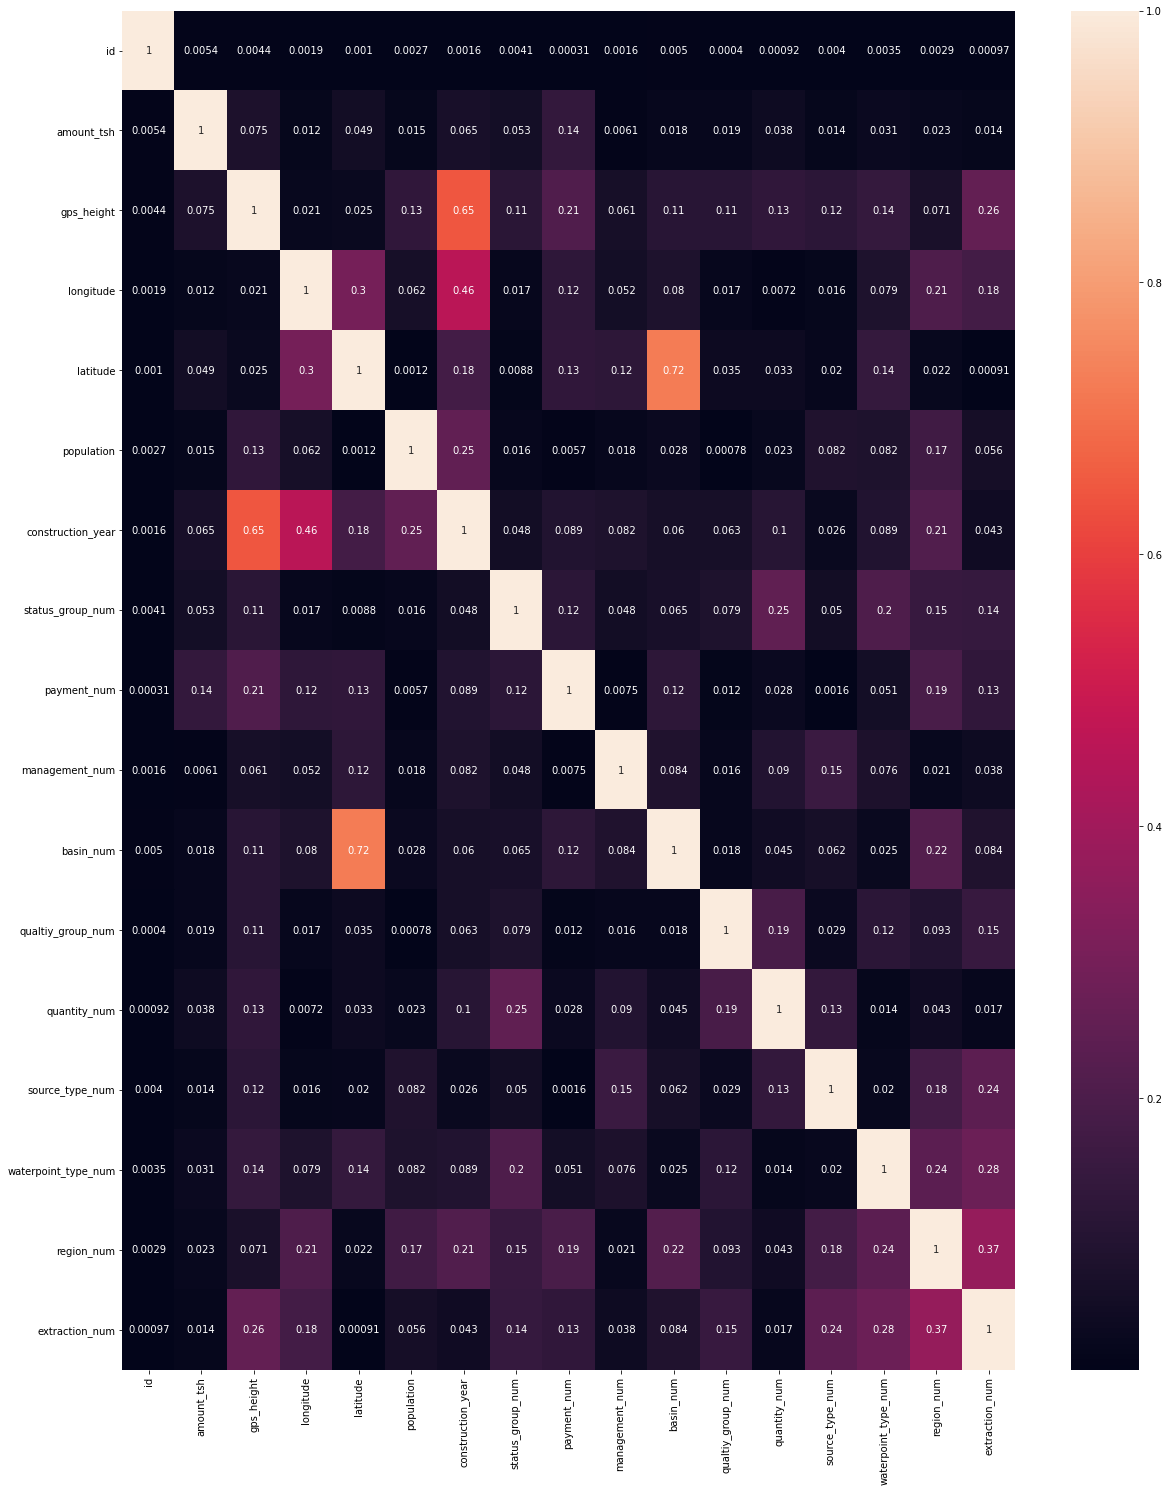

In [86]:
# Correlation Heat Map
plt.figure(figsize=(20,25))
sns.heatmap(df2.corr().abs(), annot=True)
plt.show()

In [87]:
# Creating numerical and categorical dataframe for EDA
numerical = df2[['amount_tsh', 'gps_height', 'longitude',
       'latitude', 'subvillage', 'region',
       'population', 'construction_year', 'status_group_num',
       'payment_num', 'management_num', 'basin_num', 'qualtiy_group_num',
       'quantity_num', 'source_type_num', 'waterpoint_type_num', 'region_num',
       'extraction_num']]

categorical = df2[['funder', 'installer', 'basin', 'subvillage', 
       'region', 'lga', 'ward',
       'permit', 'extraction_type_class',
       'management', 'payment_type', 'quality_group', 'quantity',
       'source_type', 'waterpoint_type', 'status_group']]

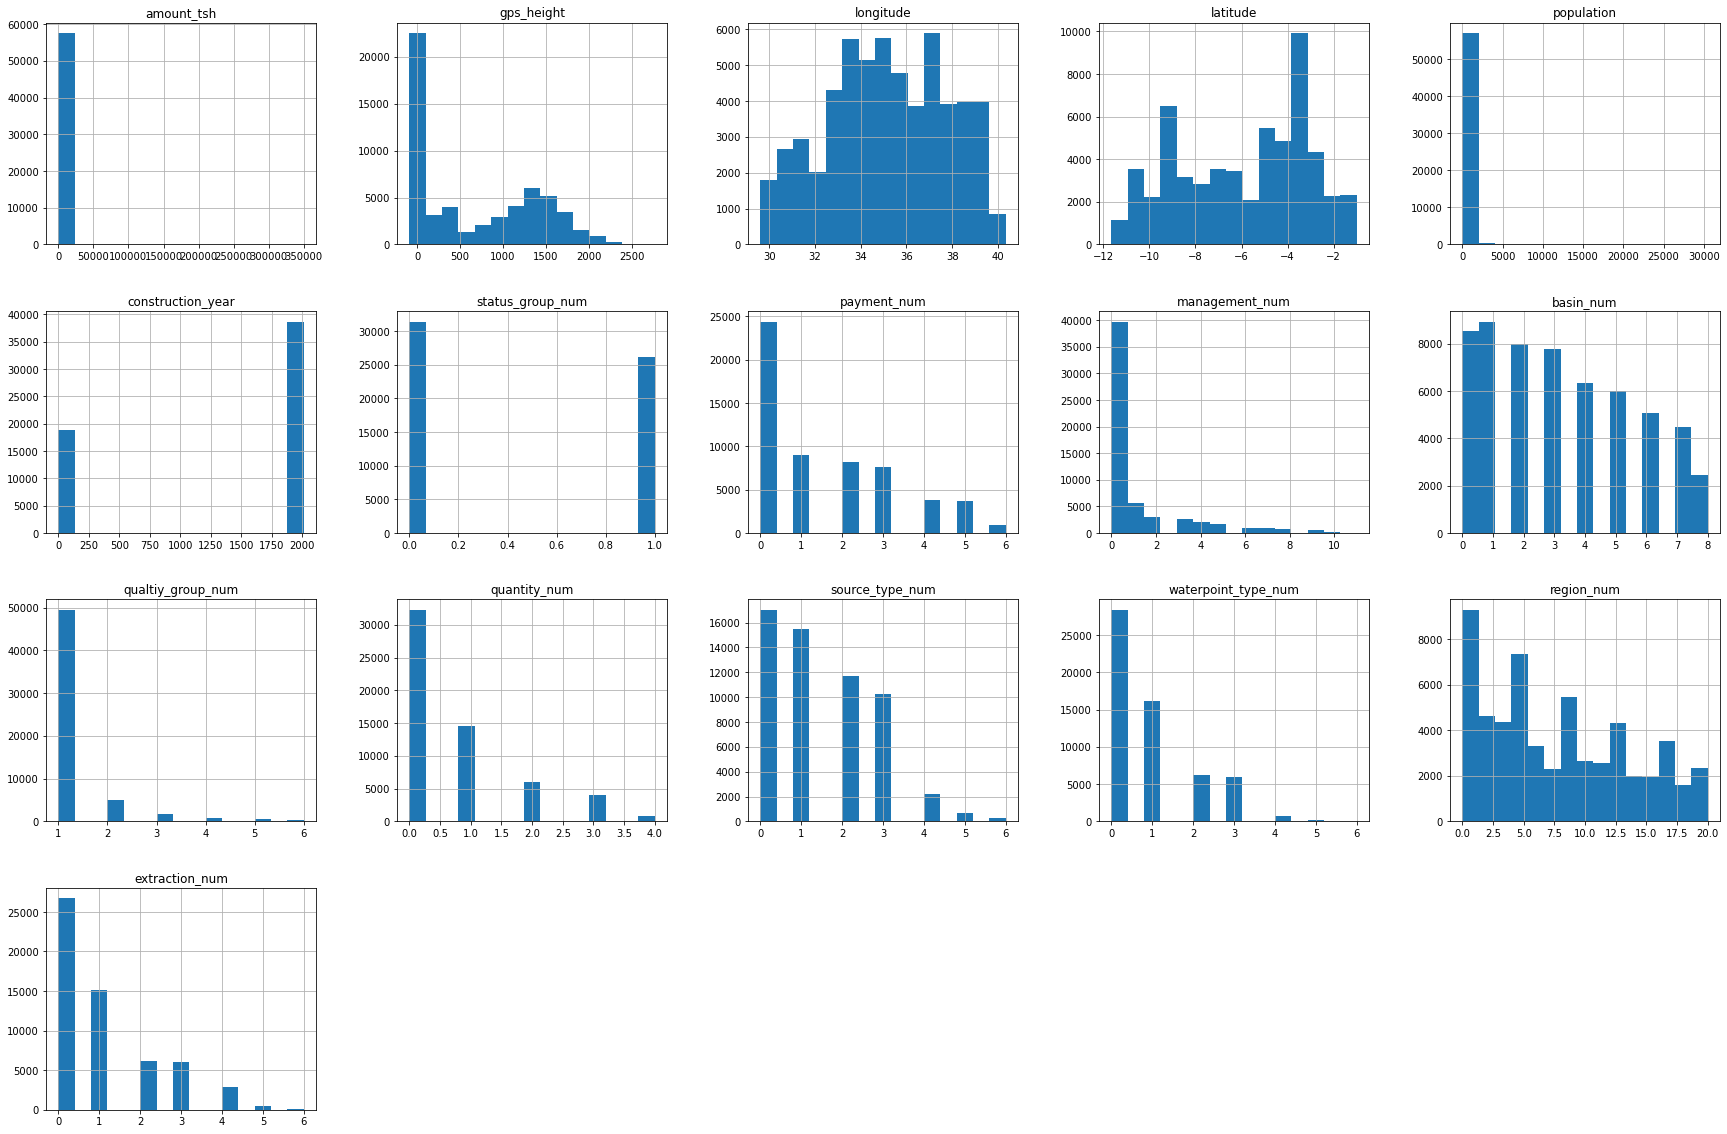

In [88]:
# Histogram EDA showing frequency of data
numerical.hist(bins=15, figsize=(30, 20), layout=(4, 5));

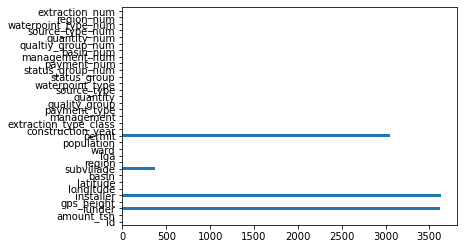

In [89]:
# EDA showing null values in our data set
df2.isnull().sum().plot(kind = 'barh');

In [90]:
# Export dataframe so we can continue in another Jupyter Notebook for greater programming focus
df2.to_csv('eda_df.csv')

In [92]:
# Import data frame to continue eda / feature engineering / modeling
water_wells = pd.read_csv("data/eda_df.csv", index_col = 0)

In [94]:
# Sanity check
display(water_wells.head())
display(water_wells.info())

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,basin,subvillage,region,...,status_group_num,payment_num,management_num,basin_num,qualtiy_group_num,quantity_num,source_type_num,waterpoint_type_num,region_num,extraction_num
0,69572,6000.0,Roman,1390,Roman,34.938093,-9.856322,Lake Nyasa,Mnyusi B,Iringa,...,0,5,0,6,1,0,0,0,0,0
1,8776,0.0,Grumeti,1399,GRUMETI,34.698766,-2.147466,Lake Victoria,Nyamara,Mara,...,0,0,1,0,1,1,4,0,14,0
2,34310,25.0,Lottery Club,686,World vision,37.460664,-3.821329,Pangani,Majengo,Manyara,...,0,1,0,1,1,0,5,3,18,0
3,67743,0.0,Unicef,263,UNICEF,38.486161,-11.155298,Ruvuma / Southern Coast,Mahakamani,Mtwara,...,1,0,0,7,1,2,2,3,17,3
4,19728,0.0,Action In A,0,Artisan,31.130847,-1.825359,Lake Victoria,Kyanyamisa,Kagera,...,0,0,7,0,1,3,4,0,6,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 57588 entries, 0 to 59399
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     57588 non-null  int64  
 1   amount_tsh             57588 non-null  float64
 2   funder                 53966 non-null  object 
 3   gps_height             57588 non-null  int64  
 4   installer              53952 non-null  object 
 5   longitude              57588 non-null  float64
 6   latitude               57588 non-null  float64
 7   basin                  57588 non-null  object 
 8   subvillage             57217 non-null  object 
 9   region                 57588 non-null  object 
 10  lga                    57588 non-null  object 
 11  ward                   57588 non-null  object 
 12  population             57588 non-null  int64  
 13  permit                 54532 non-null  object 
 14  construction_year      57588 non-null  int64  
 15  ex

None

## Creating feature called well_age to see if age plays a part in functionality

In [96]:
# Look at the value counts of construction year
water_wells['construction_year'].value_counts()

0       18897
2010     2645
2008     2613
2009     2533
2000     2091
2007     1587
2006     1471
2003     1286
2011     1256
2004     1123
2012     1084
2002     1075
1978     1037
1995     1014
2005     1011
1999      979
1998      966
1990      954
1985      945
1980      811
1996      811
1984      779
1982      744
1994      738
1972      708
1974      676
1997      644
1992      640
1993      608
2001      540
1988      521
1983      488
1975      437
1986      434
1976      414
1970      411
1991      324
1989      316
1987      302
1981      238
1977      202
1979      192
1973      184
2013      176
1971      145
1960      102
1967       88
1963       85
1968       77
1969       59
1964       40
1962       30
1961       21
1965       19
1966       17
Name: construction_year, dtype: int64

In [97]:
# Take a look at the median year
water_wells['construction_year'].median()

1988.0

In [99]:
# Copy data frame so we can create new feature
age_df = water_wells.copy()

In [100]:
# Look at median age of construction year
median_age = age_df.loc[age_df['construction_year'] != 0].median()
median_age

id                     37078.000000
amount_tsh                 0.000000
gps_height              1154.000000
longitude                 36.648187
latitude                  -6.064216
population               150.000000
permit                     1.000000
construction_year       2000.000000
status_group_num           0.000000
payment_num                1.000000
management_num             0.000000
basin_num                  3.000000
qualtiy_group_num          1.000000
quantity_num               0.000000
source_type_num            1.000000
waterpoint_type_num        0.000000
region_num                 8.000000
extraction_num             0.000000
dtype: float64

In [101]:
# Look at mean age of construction year
mean_age = age_df.loc[age_df['construction_year'] != 0].mean()
mean_age

id                     37083.008736
amount_tsh               466.457534
gps_height              1002.367760
longitude                 35.983262
latitude                  -6.235372
population               269.799617
permit                     0.717332
construction_year       1996.814686
status_group_num           0.439043
payment_num                1.620273
management_num             1.138146
basin_num                  3.314414
qualtiy_group_num          1.207438
quantity_num               0.651443
source_type_num            1.470497
waterpoint_type_num        0.804166
region_num                 8.484454
extraction_num             1.009589
dtype: float64

In [102]:
# Final Line imputing median on 0s
water_wells['construction_year'] = water_wells['construction_year'].replace(0,median_age['construction_year'])

In [103]:
# Create new feature well_age
water_wells['well_age'] = (2022 - water_wells['construction_year'])

In [104]:
# Confirm feature creation worked
water_wells['well_age'].value_counts()

22    20988
12     2645
14     2613
13     2533
15     1587
16     1471
19     1286
11     1256
18     1123
10     1084
20     1075
44     1037
27     1014
17     1011
23      979
24      966
32      954
37      945
42      811
26      811
38      779
40      744
28      738
50      708
48      676
25      644
30      640
29      608
21      540
34      521
39      488
47      437
36      434
46      414
52      411
31      324
33      316
35      302
41      238
45      202
43      192
49      184
9       176
51      145
62      102
55       88
59       85
54       77
53       59
58       40
60       30
61       21
57       19
56       17
Name: well_age, dtype: int64

## Creating graphs to show ratio of well functionality and well age. Specifically the top and bottom 10 years age groups.

In [105]:
# Create a dataframe copy to start the ratio creation
ratio_df = water_wells.copy()

In [106]:
# Group well_age and status group
ratio_df = ratio_df.groupby('well_age', as_index=False)['status_group_num'].agg(['count', 'sum']).reset_index()
ratio_df['ratio'] = 100 * ratio_df['sum'] / ratio_df['count']
ratio_df = ratio_df.rename(columns={'count': 'total_wells', 'sum': 'non-functional'})

In [107]:
# Sanity check
ratio_df.head()

,well_age,total_wells,non-functional,ratio
0,9,176,74,42.045455
1,10,1084,358,33.025830
2,11,1256,313,24.920382
3,12,2645,622,23.516068
4,13,2533,759,29.964469


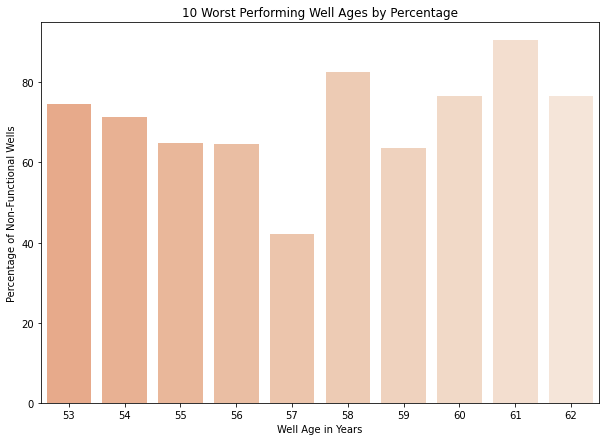

In [108]:
# Plotting relationship between well age and non-funcional well
order = ratio_df.groupby('well_age').mean().sort_values('well_age').index

plt.figure(figsize=(10,7))
sns.barplot(data=ratio_df, x='well_age', y='ratio', order=order,
           palette = 'rocket')
plt.xlim(43.5,)
plt.ylabel("Percentage of Non-Functional Wells")
plt.xlabel("Well Age in Years")
plt.title("10 Worst Performing Well Ages by Percentage");

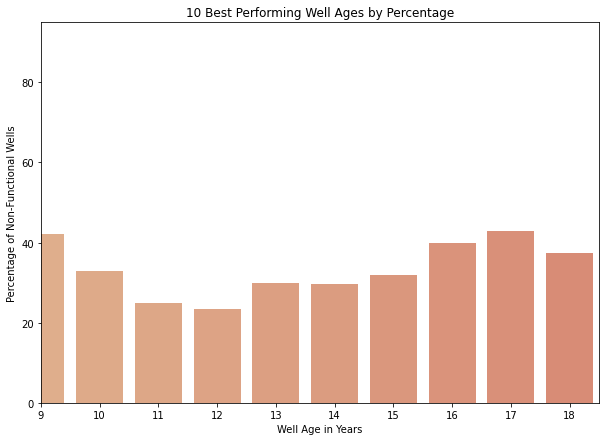

In [109]:
# Plotting relationship between well age and non-funcional well
order = ratio_df.groupby('well_age').mean().sort_values('well_age').index

plt.figure(figsize=(10,7))
sns.barplot(data=ratio_df, x='well_age', y='ratio', order=order, palette= "flare")
plt.xlim(0, 9.5)
plt.ylabel("Percentage of Non-Functional Wells")
plt.xlabel("Well Age in Years")
plt.title("10 Best Performing Well Ages by Percentage");

In [110]:
# Extraction Type vs Failure Bar Chart
extraction_ratio_df = water_wells.copy()

In [111]:
# Group extraction and status group
extraction_ratio_df = extraction_ratio_df.groupby('extraction_type_class', as_index=False)['status_group_num'].agg(['count', 'sum']).reset_index()
extraction_ratio_df['ratio'] = 100 * extraction_ratio_df['sum'] / extraction_ratio_df['count']
extraction_ratio_df = extraction_ratio_df.rename(columns={'count': 'total_wells', 'sum': 'non-functional'})

In [112]:
# Sanity check
extraction_ratio_df.head()

,extraction_type_class,total_wells,non-functional,ratio
0,gravity,26696,10674,39.983518
1,handpump,15179,5552,36.576850
2,motorpump,2939,1824,62.061926
3,other,6160,5174,83.993506
4,rope pump,451,158,35.033259


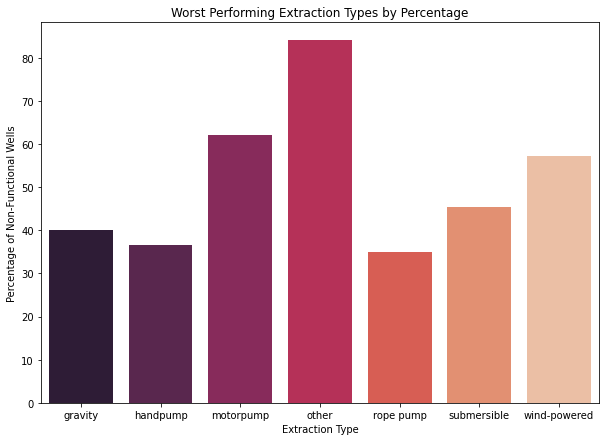

In [113]:
# Plotting relationship between well age and non-funcional well
plt.figure(figsize=(10,7))
sns.barplot(data=extraction_ratio_df, x='extraction_type_class', y='ratio', palette = 'rocket')
plt.ylabel("Percentage of Non-Functional Wells")
plt.xlabel("Extraction Type")
plt.title("Worst Performing Extraction Types by Percentage");

Next we move to the last bit of data cleaning for our data frame.

In [114]:
# Create a copy of our water_wells dataframe
splitdf = water_wells.copy()

In [117]:
# Drop permit's null values because 2400 out of the total data set size is negligible
splitdf.dropna(subset=['permit'], inplace=True)

In [118]:
splitdf.isna().sum()

id                          0
amount_tsh                  0
funder                   1204
gps_height                  0
installer                1223
longitude                   0
latitude                    0
basin                       0
subvillage                371
region                      0
lga                         0
ward                        0
population                  0
permit                      0
construction_year           0
extraction_type_class       0
management                  0
payment_type                0
quality_group               0
quantity                    0
source_type                 0
waterpoint_type             0
status_group                0
status_group_num            0
payment_num                 0
management_num              0
basin_num                   0
qualtiy_group_num           0
quantity_num                0
source_type_num             0
waterpoint_type_num         0
region_num                  0
extraction_num              0
well_age  

# Model Analysis

In [119]:
# Set up train-test split - Dropped any remaining columns with missing values (funder, installer, and subvillage)
X = splitdf.drop(columns = ['funder', 'installer',
       'basin', 'subvillage', 'region', 'lga', 'ward',
       'extraction_type_class',
       'management', 'payment_type', 'quality_group', 'quantity',
       'source_type', 'waterpoint_type', 'status_group', 'status_group_num'], axis = 1)
y = splitdf['status_group_num']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [120]:
# Look at shape
print(X_train.shape)
print(X_test.shape)
# Check the shapes to see if the split worked
print(X_train.shape[0] == y_train.shape[0])
print(X_test.shape[0] == y_test.shape[0])

(43625, 18)
(10907, 18)
True
True


### Dummy Classifier

We set up a dummy classifier model for our baseline score. This is the bare minimum score that we have to beat for our model to provide value to UNICEF and the people of Tanzania.

In [121]:
# Setting up Dummy Classifier for our baseline metrics
dummy_model = DummyClassifier(strategy="most_frequent")
dummy_model.fit(X_train, y_train)
dummy_model.predict(X_train)
dummy_model.score(X_train, y_train)

0.5458338108882521

In [122]:
# Looking at the cross val score for our dummy model
cross_val_score(dummy_model, X_train, y_train, cv = 5).mean()

0.545833810888252

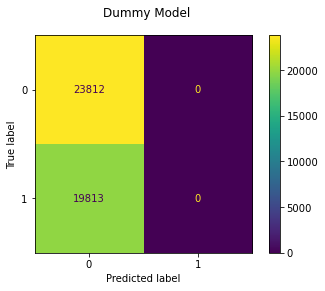

In [123]:
# Confusion matrix for the dummy model
fig, ax = plt.subplots()

fig.suptitle("Dummy Model")

plot_confusion_matrix(dummy_model, X_train, y_train, ax=ax, values_format='');

In [124]:
# Obtain the accuracy, recall score, and precision score for the dummy model
y_pred_dummy = dummy_model.predict(X_test)

accuracy_dummy = accuracy_score(y_test, y_pred_dummy)
recall_dummy = recall_score(y_test, y_pred_dummy)
precision_dummy = precision_score(y_test, y_pred_dummy)

print(f"""
- Dummy Model - 
Accuracy score: {accuracy_dummy}
Recall score: {recall_dummy}
Precision score: {precision_dummy}
""")


- Dummy Model - 
Accuracy score: 0.5413037498853946
Recall score: 0.0
Precision score: 0.0



Although we decide to go with Recall as our main metric. (Better safe than sorry when it comes to water wells) The accuracy score is the minimum score we will need to hit for the rest of our models.

### Decision Tree Model

For our next model we decide to go with a decision tree model so that we can try to discern what our most important features are in our dataset.

In [125]:
# Instante and fit the Decision Tree Model
tree_clf = DecisionTreeClassifier(max_depth=4, random_state=42)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=42)

In [126]:
# Score on train and test data to see if we are overfitting
print(f'Train Accuracy Score:{tree_clf.score(X_train, y_train)}')
print(f'Test Accuracy Score:{tree_clf.score(X_test, y_test)}')

Train Accuracy Score:0.7261203438395415
Test Accuracy Score:0.7238470706885486


In [127]:
# Predictions on test
y_pred = tree_clf.predict(X_test)

# Recall score
recall = recall_score(y_test, y_pred)
print(f"Recall score: {recall}")

Recall score: 0.528083150109934


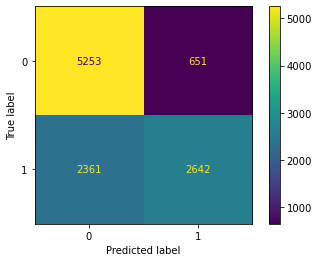

In [128]:
# Plot a confusion matrix
plot_confusion_matrix(tree_clf, X_test, y_test);

In [129]:
# Feature importance 
feat_import = {name: score 
                   for name, score 
                       in zip(X_train.columns, tree_clf.feature_importances_)
}
feat_import

{'id': 0.0,
 'amount_tsh': 0.06389757959188014,
 'gps_height': 0.007065792537314767,
 'longitude': 0.008413611969309166,
 'latitude': 0.001347677023509384,
 'population': 0.0,
 'permit': 0.0,
 'construction_year': 0.045920673467083443,
 'payment_num': 0.0,
 'management_num': 0.0,
 'basin_num': 0.0,
 'qualtiy_group_num': 0.0,
 'quantity_num': 0.4315405820639554,
 'source_type_num': 0.014039318002151368,
 'waterpoint_type_num': 0.376360419863301,
 'region_num': 0.014942911056437585,
 'extraction_num': 0.0,
 'well_age': 0.03647143442505767}

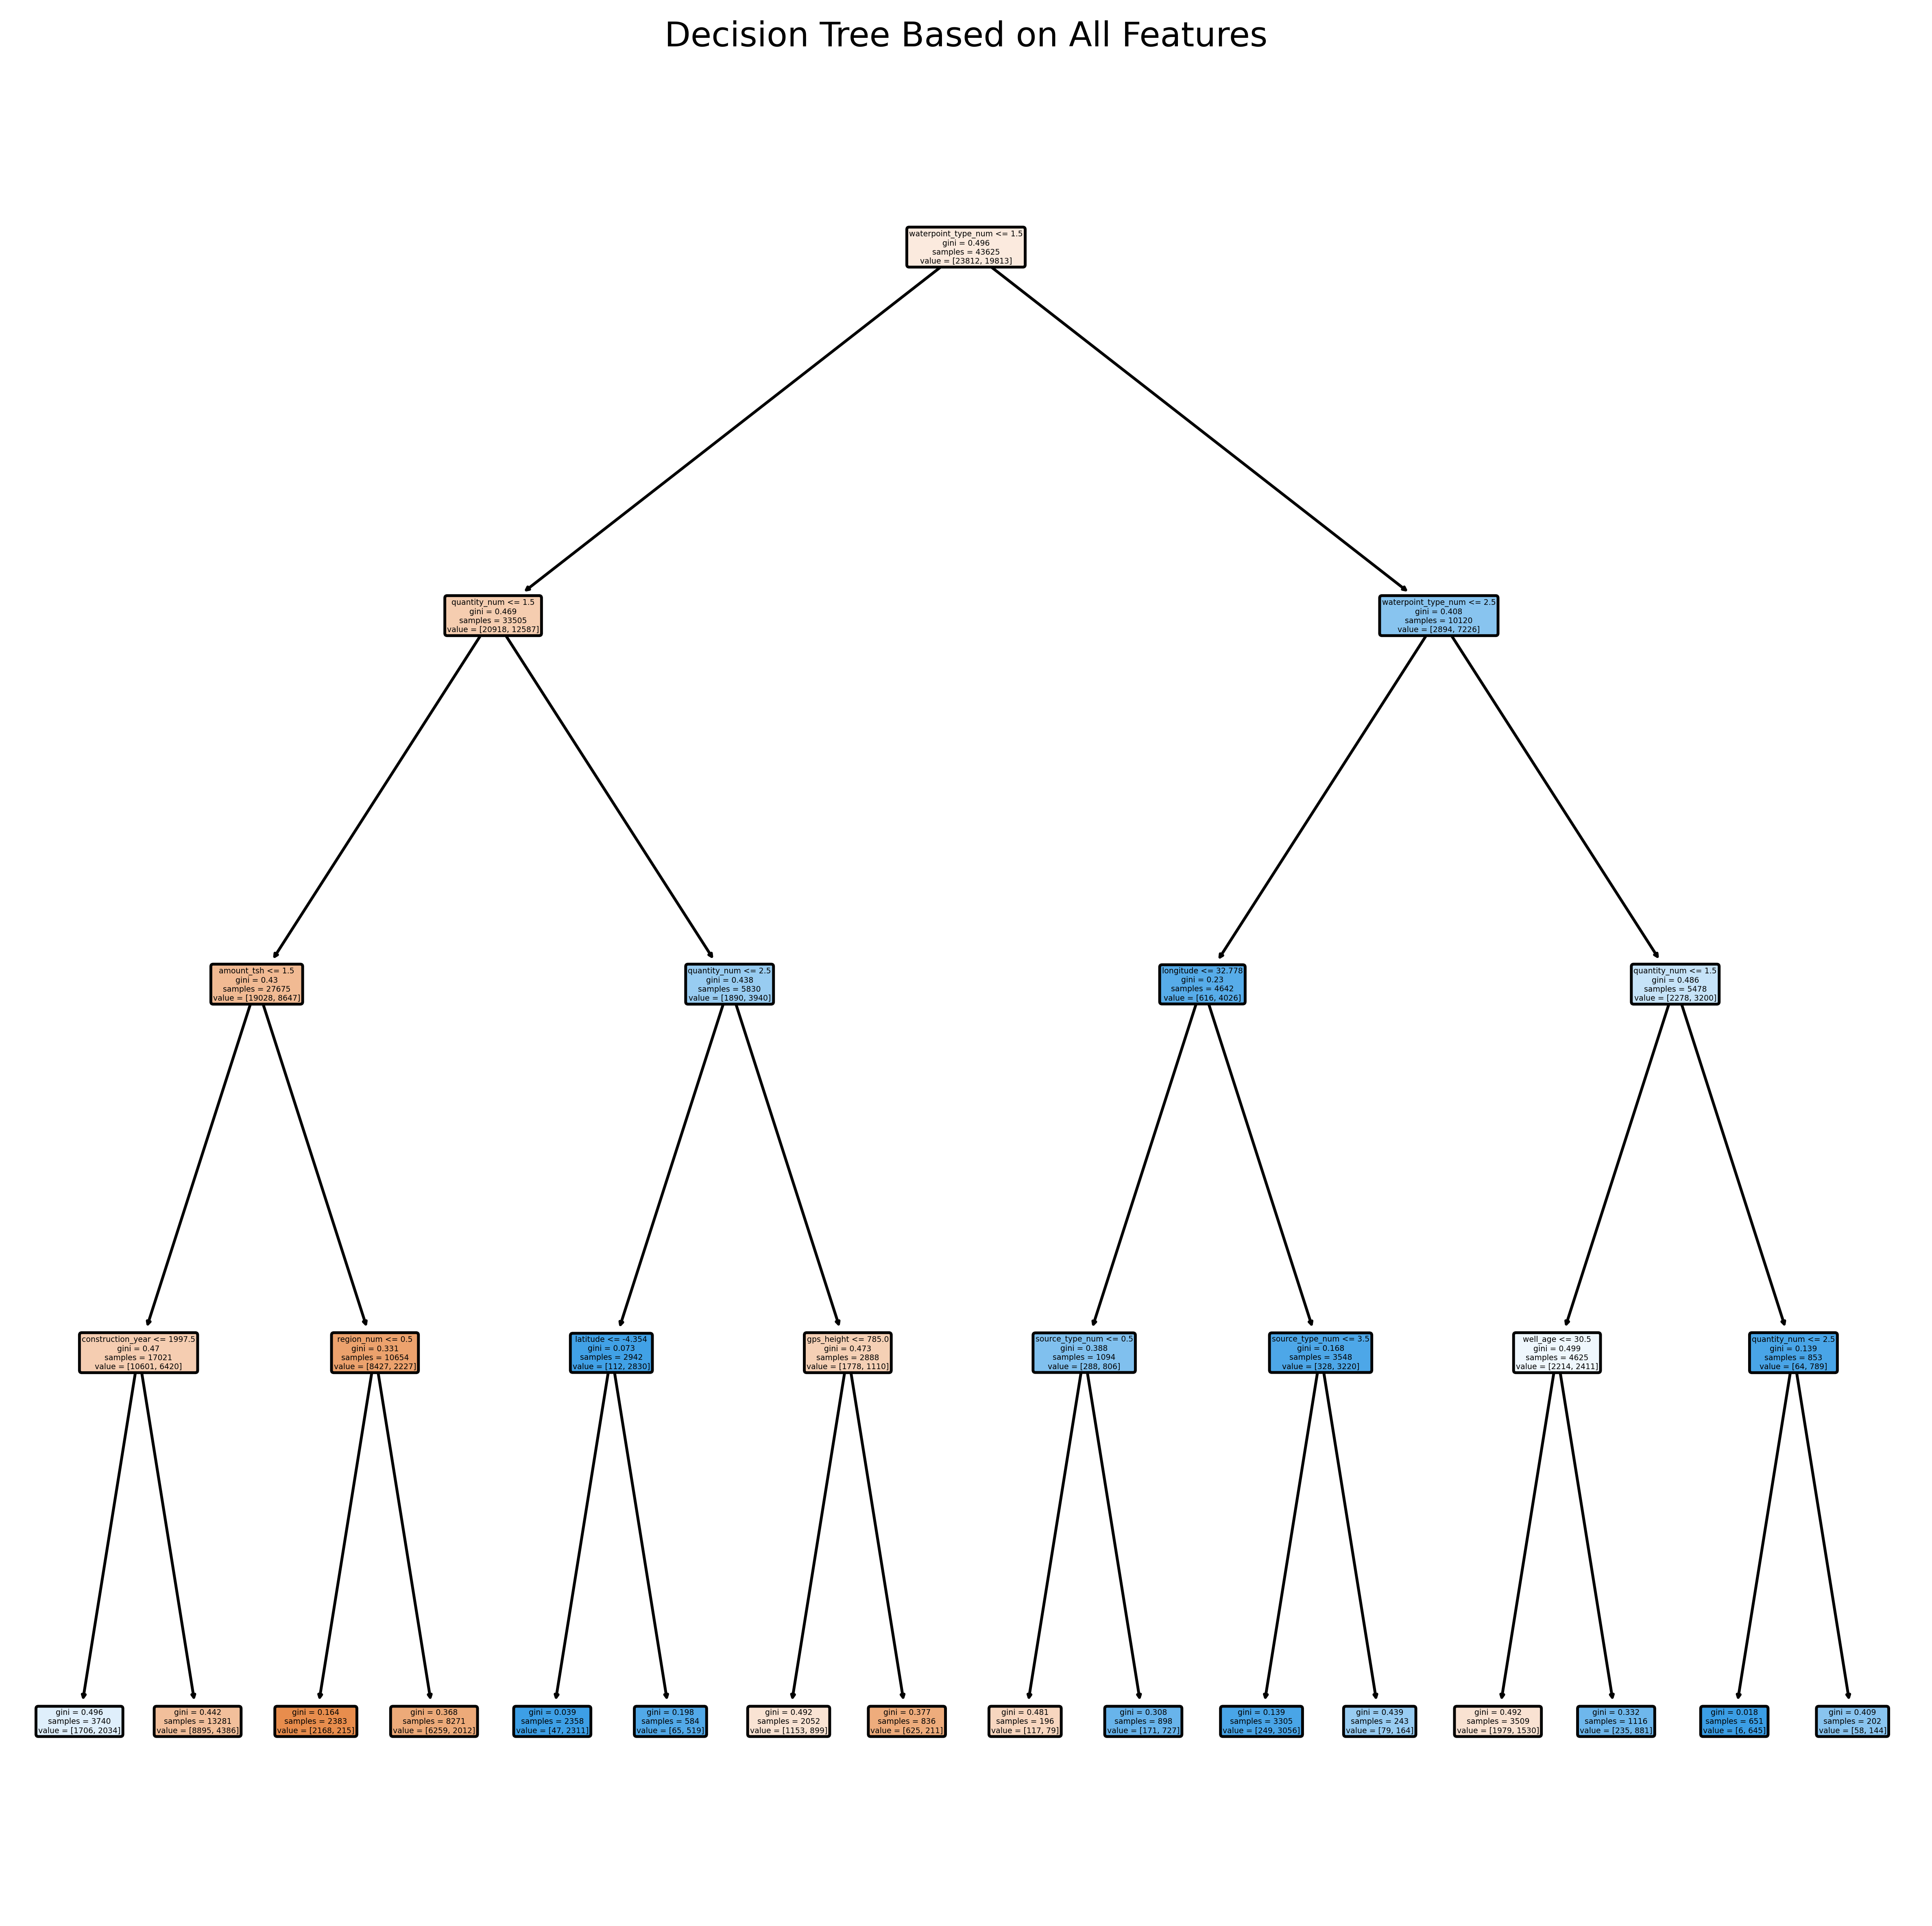

In [131]:
# Plot our decision tree
plt.figure(figsize=(12,12), dpi = 500)
plot_tree(tree_clf,
 feature_names = X.columns,
 filled = True, rounded = True)
plt.title("Decision Tree Based on All Features")
plt.show()

Takeaway here is that anything related to the geographic area of where the well is located (latitude), extraction_num, and quantity.

### Standard Scaling our Data and performing a Simple Logistic Regression

Our next model is a simple logistic regression. We hope to beat our previous models recall score and continue this iterative process.

In [133]:
# Instante and scale data
scale = StandardScaler()
X_train_scaled = scale.fit_transform(X_train)
X_test_scaled = scale.transform(X_test)

simple_log_model = LogisticRegression(random_state=42)
simple_log_model.fit(X_train_scaled, y_train)

LogisticRegression(random_state=42)

In [134]:
#predictions on test
y_pred = simple_log_model.predict(X_test_scaled)

#recall score
recall = recall_score(y_test, y_pred)
print(f"Recall score: {recall}")

Recall score: 0.5864481311213272


In [135]:
# Trying to figure out how to interpret a multinomial log loss
log_loss(y_test, simple_log_model.predict_proba(X_test_scaled))

0.5924743969151737

In [136]:
# Checking out to see if we overfit the data or not
y_pred_train = simple_log_model.predict(X_train_scaled)
y_pred_test = simple_log_model.predict(X_test_scaled)

print(f"Train Recall Score: {recall_score(y_train, y_pred_train)}")
print(f"Test Recall Score: {recall_score(y_test, y_pred_test)}")

Train Recall Score: 0.5866855095139555
Test Recall Score: 0.5864481311213272


### Running a Grid Search with our Logistic Regression Model

After running our Logistic Regression and getting a recall score of .586 for our test data set, we ran a grid search to hopefully tease out the most effect hyperparameters.

In [137]:
#logistic regression grid
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [1e-3, 1e-1, 1e2, 1e4, 1e6],
    'solver': ['lbfgs', 'liblinear'],
    'class_weight': ['balanced', None]
}

In [138]:
#GridSearchCV
grid_search = GridSearchCV(simple_log_model, param_grid, cv=3)
grid_search.fit(X_train_scaled, y_train)

print("Best Parameter Combination Found During Grid Search:")
grid_search.best_params_

Best Parameter Combination Found During Grid Search:


{'C': 100.0, 'class_weight': None, 'penalty': 'l2', 'solver': 'lbfgs'}

### Rerunning our Logistic Regression

In [139]:
# Change hyperparameters to reflect GridSearch Results
grid1_log_model = LogisticRegression(random_state=42, C= 100.0, 
                                      class_weight= None, penalty= 'l2', 
                                      solver= 'lbfgs')
grid1_log_model.fit(X_train_scaled, y_train)

LogisticRegression(C=100.0, random_state=42)

In [140]:
# Predictions on test
y_pred_grid = grid1_log_model.predict(X_test_scaled)

# Recall Score
recall_grid = recall_score(y_test, y_pred_grid)
print(f"Recall score: {recall_grid}")

Recall score: 0.5864481311213272


Turns out we lucked into getting the most effective hyperparameters!

### Trying out Randomized Search CV

Continued with our attempts to improve our logistic regression... To no avail.

In [142]:
# Set up a Randomized Search for our Simple Logistic Regression
distributions = dict(C=uniform(loc=0, scale=4),
                      penalty=['l2', 'l1'])
rando_search = RandomizedSearchCV(simple_log_model, distributions, random_state=0)
search = rando_search.fit(X_train, y_train)
search.best_params_

{'C': 1.75034884505077, 'penalty': 'l2'}

In [143]:
# Change hyperparameters to reflect Randomized Search Results
rando1_log_model = LogisticRegression(random_state=42, C= 2.4942547871438894, 
                                      penalty= 'l2')
rando1_log_model.fit(X_train_scaled, y_train)

LogisticRegression(C=2.4942547871438894, random_state=42)

In [144]:
# Predictions on test
y_pred_grid = rando1_log_model.predict(X_test_scaled)

# Recall Score
recall_grid = recall_score(y_test, y_pred_grid)
print(f"Recall score: {recall_grid}")

Recall score: 0.5864481311213272


### Potentially trying to perform an ROC Curve Analysis

An attempt at visualize our logistic regression model. This is solely for our own eyes as this graph is not very stakeholder friendly.

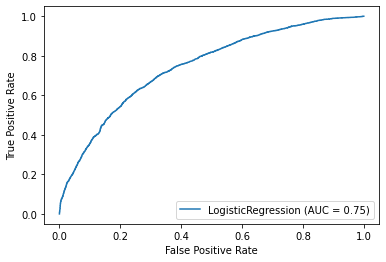

In [145]:
# Perform an ROC Curve to see how well our data performs
plot_roc_curve(simple_log_model, X_test_scaled, y_test);

### Random Forest Modeling

In our iterative process we decided to try a random forest model.

In [146]:
# Instantiate the Decision Tree
ct = DecisionTreeClassifier(random_state=42)

ct.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [147]:
# Find max_samples amount
X_train.shape

(43625, 18)

In [148]:
# Instantiate the Random Forest Model
rfc = RandomForestClassifier(max_features='sqrt',
                            max_samples=None,
                            random_state=42)

In [149]:
# Fit the model 
rfc.fit(X_train, y_train)

RandomForestClassifier(max_features='sqrt', random_state=42)

In [150]:
scores = cross_val_score(estimator=rfc, X=X_train,
               y=y_train, cv=5)
scores

array([0.8113467 , 0.81363897, 0.81169054, 0.81948424, 0.81455587])

In [151]:
# Cross val scores averaged
scores.mean()

0.8141432664756447

              precision    recall  f1-score   support

           0       0.81      0.87      0.84      5904
           1       0.83      0.76      0.79      5003

    accuracy                           0.82     10907
   macro avg       0.82      0.81      0.81     10907
weighted avg       0.82      0.82      0.82     10907



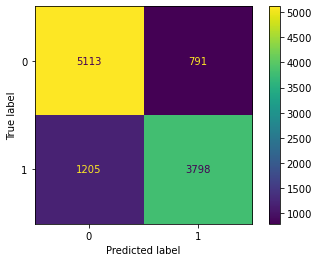

In [152]:
# Test set predictions
pred = rfc.predict(X_test)

# Confusion matrix and classification report
print(plot_confusion_matrix(rfc, X_test, y_test));
print(classification_report(y_test, pred));

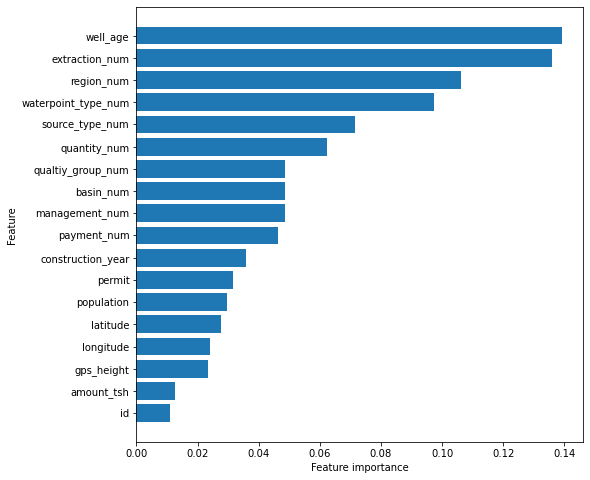

In [153]:
# Create a function to help plot models so we can potentially view feature importance of every model we run
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    sorted_idx = rfc.feature_importances_.argsort()
    plt.barh(range(n_features), model.feature_importances_[sorted_idx], align='center')
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(rfc)

From our Random Forest Model, we start to see that our top 3 features are `well_age`, `extraction_num`, and `region_num`. We also have our highest recall score yet at 76%

### Random Forest Model with changed threshold to try and improve recall score

In [154]:
# With predict the probability we see that the lower the threshold 
threshold = .6

predicted_proba_train = rfc.predict_proba(X_train)
predicted_train = (predicted_proba_train [:,1] >= threshold).astype('int')

predicted_proba_test = rfc.predict_proba(X_test)
predicted_test = (predicted_proba_test [:,1] >= threshold).astype('int')

training_recall = recall_score(y_train, predicted_train)
test_recall = recall_score(y_test, predicted_test)

print('Training Recall: {:.4}%'.format(training_recall * 100))
print('Validation Recall: {:.4}%'.format(test_recall * 100))

Training Recall: 99.53%
Validation Recall: 69.36%


Threshold for the Random Forest model was changed to improve recall, however this ended up overfitting our model significantly.

### XGBoost

Our next model was done with XGBoost.

In [155]:
# Set up train-test split - Dropped columns that didn't do well in our Decision Tree ('qualtiy_group_num', 'permit', 'id')
X = splitdf.drop(columns = ['funder', 'installer', 'extraction_type_class',
       'basin', 'subvillage', 'region', 'lga', 'ward',
       'management', 'payment_type', 'quality_group', 'quantity',
       'source_type', 'waterpoint_type', 'status_group', 'status_group_num',
       'qualtiy_group_num', 'permit', 'id'], axis = 1)
y = splitdf['status_group_num']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [156]:
# Instantiate the encoder
encoder = LabelEncoder()

# Fit and transform the training data
y_train = pd.Series(encoder.fit_transform(y_train))

# Transform the test data
y_test = pd.Series(encoder.transform(y_test))

In [157]:
# Confirm Y values start at 0
y_train.value_counts().sort_index()

0    23812
1    19813
dtype: int64

In [158]:
# Confirm Y values start at 0
y_test.value_counts().sort_index()

0    5904
1    5003
dtype: int64

In [159]:
# Instantiate XGBClassifier
boost_clf = XGBClassifier()

# Fit XGBClassifier
boost_clf.fit(X_train, y_train)

# Predict on training and test sets
training_preds = boost_clf.predict(X_train)
test_preds = boost_clf.predict(X_test)

# Accuracy of training and test sets
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

Training Accuracy: 85.33%
Validation accuracy: 80.83%


In [160]:
# Checking Recall Score of training and test sets
training_recall = recall_score(y_train, training_preds)
test_recall = recall_score(y_test, test_preds)

print('Training Recall: {:.4}%'.format(training_recall * 100))
print('Validation Recall: {:.4}%'.format(test_recall * 100))

Training Recall: 77.77%
Validation Recall: 72.52%


In [161]:
X_train.columns

Index(['amount_tsh', 'gps_height', 'longitude', 'latitude', 'population',
       'construction_year', 'payment_num', 'management_num', 'basin_num',
       'quantity_num', 'source_type_num', 'waterpoint_type_num', 'region_num',
       'extraction_num', 'well_age'],
      dtype='object')

While the model was effective, it did not beat our random forest recall rate of 76%.

### GridSearch on our XGBoost

We attempted to use a grid search to help improve the metrics for our XGBoost model.

In [163]:
# Creating the parameter grid for our GridSearch
param_grid = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [6, 10],
    'min_child_weight': [1, 2],
    'subsample': [0.5, 0.7],
    'n_estimators': [100],
}

# Finding the best XGBoost model for Recall
grid_clf_boost = GridSearchCV(boost_clf, param_grid, scoring='recall', cv=None, n_jobs=1)
grid_clf_boost.fit(X_train, y_train)

best_parameters = grid_clf_boost.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = grid_clf_boost.predict(X_train)
test_preds = grid_clf_boost.predict(X_test)
training_recall = recall_score(y_train, training_preds)
test_recall = recall_score(y_test, test_preds)

print('')
print('Training Recall: {:.4}%'.format(training_recall * 100))
print('Validation Recall: {:.4}%'.format(test_recall * 100))

The above text is the code we used for our grid search XGBoost. The viewer can turn this text box back into a code cell if they so desire. Otherwise, this has been markdowned out to reduce resource usage.

The following metrics are the results of the above grid search.

C: 0.001 class_weight: 'balanced' penalty: 'l1' solver: 'lbfgs'

Training Recall: 77.77% Validation Recall: 72.52%

Again, no effect was had with our gridsearch to improve our XGBoost model. Potentially need to add more hyperparameters?

### Pipeline for KNN Model

Our last model attempted was KNN.

In [166]:
# Build a pipeline with StandardScaler and KNN
scaled_pipeline = Pipeline([('ss', StandardScaler()),
                            ('KNN', KNeighborsClassifier())])

In [167]:
# Define grid for search
grid_knn = [{'KNN__n_neighbors': [2, 3, 5]}]

In [168]:
# Define the grid search
gridsearch = GridSearchCV(estimator=scaled_pipeline,
                          param_grid=grid_knn,
                          scoring='recall',
                          cv=5,
                          error_score='raise')

In [169]:
# Fit the training data
gridsearch.fit(X_train, y_train)

# Print the recall on the test set
print(gridsearch.score(X_test, y_test))

0.739356386168299


While better than several of our other models, KNN did not beat our Random Forest Model Recall of 78%.

# Final Recommendations

We recommend that UNICEF pay close attention to older wells and allocate more resources to restoring older wells. While UNICEF cannot change the terrain in Tanzania, the organization can research efforts to construct more sustainable water source options that require less oversight than traditional wells. Finally, we recommended that UNICEF renovate wells that use motor pumps in favor of rope pumps.